# Clustering analysis of CTCF binding sites and their orientation

In [228]:
import src
import pandas as pd
import numpy as np
from scipy.stats import binom_test
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import dask.dataframe as dd
from collections import defaultdict
import itertools
from pybedtools.bedtool import BedTool
from pybedtools import cleanup

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
import seaborn as sns

figure_path = src.figures_path / "ctcf_clustering"
os.makedirs(figure_path, exist_ok=True)

cleanup()

## Clustering CTCF sites by distance
We clusterize the CTCF sites based on their relative distance. Two CTCF sites will belong to the same cluster if the distance between them is less or equal to a specified threshold (see the `distance` parameter later).

In [2]:
ctcfs = pd.read_csv(src.processed_data_path / "ctcfs.tsv", sep="\t")
ctcfs['ctcf_id'] = ctcfs.index
ctcfs.head()

chr   start     end orientation  ctcf_id
0  chr1  237593  237953           >        0
1  chr1  521337  521697           >        1
2  chr1  714087  714447           >        2
3  chr1  805232  805362           >        3
4  chr1  839966  840326           >        4

In [3]:
def strideby(v, k):
    res = np.zeros((v.shape[0] - k + 1, k), dtype=int)
    for i in range(v.shape[0] - k + 1):
        res[i, :] = v[i: i + k]
    return res

def cluster_ctcf_sites(ctcfs, distance):
    return BedTool.from_dataframe(ctcfs).cluster(d=distance).to_dataframe(names=ctcfs.columns.tolist() + ['cluster'])

def find_kmers(orientations, k, alphabet=['>', '<']):
    orientations = np.array(list(orientations))
    patterns = defaultdict.fromkeys(
        list(map(lambda x: "".join(x), itertools.product(alphabet, repeat=k))), 0)

    for i in range(orientations.shape[0] - k + 1):
        current_window = "".join(orientations[i: i + k])
        patterns[current_window] = patterns[current_window] + 1
    return dict(patterns)

def find_patterns(orientations, from_k=1, to_k=3):
    all_mers = dict()
    for i in range(from_k, to_k + 1):
        i_mers = find_kmers(orientations, i)
        all_mers.update(i_mers)
    return all_mers


def get_pattern_count(ctcf_clusters, from_k, to_k, npartitions=10):
    ctcf_clusters = dd.from_pandas(ctcf_clusters, npartitions=npartitions)
    ctcf_clusters_pattern_counts = ctcf_clusters.groupby("cluster")['orientation']\
                                                .agg(sum)\
                                                .map(lambda x: find_patterns(x, from_k, to_k), meta=('cluster', object))\
                                                .compute()
    ctcf_clusters_pattern_counts = pd.DataFrame(index=ctcf_clusters_pattern_counts.index, data=ctcf_clusters_pattern_counts.tolist())
    patterns = sorted(ctcf_clusters_pattern_counts.columns, key=len)
    ctcf_clusters_pattern_counts = ctcf_clusters_pattern_counts[patterns]
    return ctcf_clusters_pattern_counts


def normalize_by_length(ctcf_clusters_pattern_counts):
    res = []
    for p in ctcf_clusters_pattern_counts.columns:
        res.append(ctcf_clusters_pattern_counts[p] * (2**len(p)))
    return pd.concat(res, axis=1)

__categories = {
    '>>>': 'S',
    '<<<': 'S',
    '><<': 'C',
    '>><': 'C',
    '<>>': 'D',
    '<<>': 'D',
    '<><': 'CD',
    '><>': 'CD',
    'T': 'T'
}

__categories = defaultdict(lambda: np.NaN, __categories)

def to_triplets(x):
    res = []
    if len(x) > 0:
        res.append(["T"])
        if len(x) > 1:
            for i in range(1, len(x) - 1):
                res.append(x[i - 1: i + 2])
            res.append(["T"])
    return res

In [4]:
distance = 1e9
ctcf_clusters = cluster_ctcf_sites(ctcfs, distance)

In [131]:
window_swap = [[1,       20,     30,     40,     50,     60,     70,     80,     90],       
               [100,     200,    300,    400,    500,    600,    700,    800,    900],
               [1000,    2000,   3000,   4000,   5000,   6000,   7000,   8000,   9000], 
               [10000,   20000,  30000,  40000,  50000,  60000,  70000,  80000,  90000],
               [100000,  200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000,
                int(1e6)]]
ws = [x for y in window_swap for x in y]

### Number of clusters VS clustering window

In [60]:
extended_ws = ws + list(np.arange(2,10)*int(1e6)) + list(np.arange(1,11)*int(1e7))

In [61]:
all_clusters = ctcfs.copy()
for w in src.progress(extended_ws):
    wclusters = cluster_ctcf_sites(ctcfs, w)
    wclusters.rename(columns={"cluster": '{}'.format(w)}, inplace=True)
    all_clusters = all_clusters.merge(wclusters, on=ctcfs.columns.tolist())
all_clusters.head()

chr   start     end orientation  ctcf_id  1  20  30  40  50  ...  \
0  chr1  237593  237953           >        0  1   1   1   1   1  ...   
1  chr1  521337  521697           >        1  2   2   2   2   2  ...   
2  chr1  714087  714447           >        2  3   3   3   3   3  ...   
3  chr1  805232  805362           >        3  4   4   4   4   4  ...   
4  chr1  839966  840326           >        4  5   5   5   5   5  ...   

   10000000  20000000  30000000  40000000  50000000  60000000  70000000  \
0         1         1         1         1         1         1         1   
1         1         1         1         1         1         1         1   
2         1         1         1         1         1         1         1   
3         1         1         1         1         1         1         1   
4         1         1         1         1         1         1         1   

   80000000  90000000  100000000  
0         1         1          1  
1         1         1          1  
2         1         1          1  
3         1         1          1  
4         1         1          1  

[5 rows x 70 columns]

In [71]:
csize = []
for w in src.progress(all_clusters.columns[5:]):
    d = all_clusters.groupby(str(w)).agg({'start': 'min', 'end': 'max', 'ctcf_id': 'count'})
    d['cluster_size'] = d.end - d.start
    df = pd.DataFrame({'window': int(w), 'cluster_id': d.index, 'n_ctcfs': d.ctcf_id, 'cluster_size': d.cluster_size})
    csize.append(df)
csize = pd.concat(csize, axis=0)
csize.head()

window  cluster_id  n_ctcfs  cluster_size
1       1           1        1           360
2       1           2        1           360
3       1           3        1           360
4       1           4        1           130
5       1           5        1           360

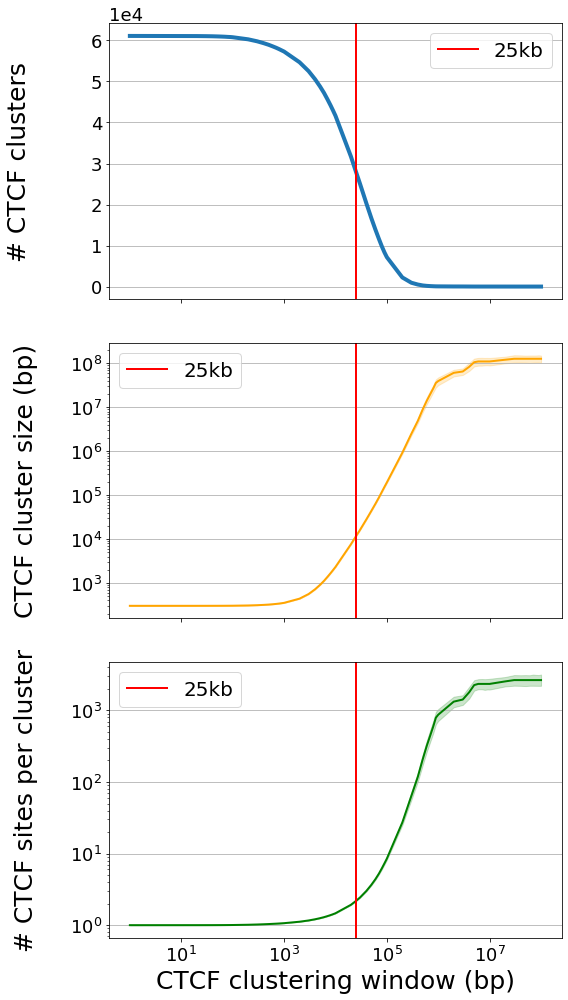

In [63]:
fig, axes = plt.subplots(3,1, sharex=True, tight_layout=True, figsize=(8,14))
# number of clusters VS clustering window
axes[0].plot(extended_ws, all_clusters.iloc[:, 5:].nunique(), linewidth=4)
axes[0].grid(axis='y')
axes[0].axvline(25000, color='red', label='25kb')
axes[0].set_xscale("log")
axes[0].set_ylabel("# CTCF clusters\n\n", fontsize=25)
axes[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[0].legend(fontsize=20)

# Cluster size VS clustering window
sns.lineplot(data=csize, x='window', y='cluster_size', color='orange', ax=axes[1])
axes[1].grid(axis='y')
axes[1].axvline(25000, color='red', label='25kb')
axes[1].set_yscale("log")
axes[1].set_ylabel("CTCF cluster size (bp)\n", fontsize=25)
axes[1].legend(fontsize=20)

# number of CTCF sites per cluster VS clustering window
sns.lineplot(data=csize, x='window', y='n_ctcfs', color='green', ax=axes[2])
axes[2].grid(axis='y')
axes[2].axvline(25000, color='red', label='25kb')
axes[2].set_yscale("log")
axes[2].set_ylabel("# CTCF sites per cluster\n", fontsize=25)
axes[2].legend(fontsize=20)

plt.xlabel("CTCF clustering window (bp)", fontsize=25)
fig.savefig(figure_path / "CTCF_clusters_stats.pdf", bbox_inches='tight', transparent=True)
plt.show()

### What about a random spatial distribution of CTCF sites?

In [118]:
shuffled_ctcf_sites = BedTool.from_dataframe(ctcfs).shuffle(genome='hg19', chrom=True).sort().to_dataframe(names=ctcfs.columns.tolist())
shuffled_ctcf_sites.head()

chr   start     end orientation  ctcf_id
0  chr1   23404   23585           >     4871
1  chr1   86127   86331           <     4638
2  chr1  116525  116775           >     1141
3  chr1  180943  181303           <     3016
4  chr1  204629  205055           >     2818

In [119]:
distances_between_shuffled_ctcfs = shuffled_ctcf_sites.shift(-1).start - shuffled_ctcf_sites.end
distances_between_shuffled_ctcfs = distances_between_shuffled_ctcfs[(distances_between_shuffled_ctcfs > 0) & (distances_between_shuffled_ctcfs < 1e7)]

In [120]:
distances_between_shuffled_ctcfs.median()

33232.5

In [121]:
all_clusters_random = shuffled_ctcf_sites.copy()
for w in src.progress(extended_ws):
    wclusters = cluster_ctcf_sites(shuffled_ctcf_sites, w)
    wclusters.rename(columns={"cluster": '{}'.format(w)}, inplace=True)
    all_clusters_random = all_clusters_random.merge(wclusters, on=shuffled_ctcf_sites.columns.tolist())
all_clusters_random.head()

chr   start     end orientation  ctcf_id  1  20  30  40  50  ...  \
0  chr1   23404   23585           >     4871  1   1   1   1   1  ...   
1  chr1   86127   86331           <     4638  2   2   2   2   2  ...   
2  chr1  116525  116775           >     1141  3   3   3   3   3  ...   
3  chr1  180943  181303           <     3016  4   4   4   4   4  ...   
4  chr1  204629  205055           >     2818  5   5   5   5   5  ...   

   10000000  20000000  30000000  40000000  50000000  60000000  70000000  \
0         1         1         1         1         1         1         1   
1         1         1         1         1         1         1         1   
2         1         1         1         1         1         1         1   
3         1         1         1         1         1         1         1   
4         1         1         1         1         1         1         1   

   80000000  90000000  100000000  
0         1         1          1  
1         1         1          1  
2         1         1          1  
3         1         1          1  
4         1         1          1  

[5 rows x 70 columns]

In [122]:
distances_between_ctcfs = ctcfs.shift(-1).start - ctcfs.end
distances_between_ctcfs = distances_between_ctcfs[(distances_between_ctcfs > 0) & (distances_between_ctcfs < 1e7)]

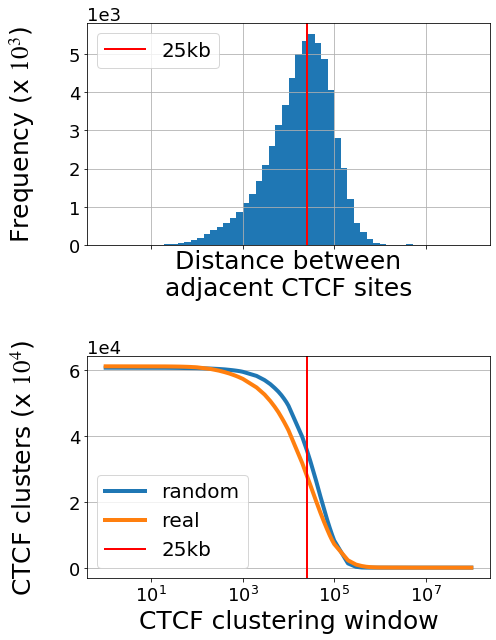

In [302]:
fig, axes = plt.subplots(2, 1, sharex=True, tight_layout=True, figsize=(7, 9))
axes[0].hist(distances_between_ctcfs, bins=np.logspace(0,7))
axes[0].set_xscale("log")
axes[0].grid()
axes[0].axvline(25000, color='red', label='25kb')
axes[0].legend(fontsize=20, loc='upper left')
axes[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[0].set_ylabel("Frequency (x $10^3$)\n", fontsize=25)
axes[0].set_xlabel("Distance between\nadjacent CTCF sites\n", fontsize=25)

axes[1].plot(extended_ws, all_clusters_random.iloc[:, 5:].nunique(), linewidth=4, label='random')
axes[1].plot(extended_ws, all_clusters.iloc[:, 5:].nunique(), linewidth=4, label='real')
axes[1].grid(axis='y')
axes[1].axvline(25000, color='red', label='25kb')
axes[1].set_xlabel("CTCF clustering window", fontsize=25)
axes[1].set_ylabel("CTCF clusters (x $10^4$)\n", fontsize=25)
axes[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[1].legend(fontsize=20, loc='lower left')
plt.show()

## Stratifying the CTCF sites based on their two neighbours

In [ ]:
ctcf_clusters_categories = ctcf_clusters.groupby("cluster").orientation\
                                        .sum()\
                                        .map(lambda x: to_triplets(list(x)))\
                                        .map(lambda x: list(map(lambda y: __categories["".join(y)], x)))
cats = ctcf_clusters_categories.sum()

In [ ]:
for c in src.progress(ctcf_clusters_categories.index):
    ctcf_clusters.loc[ctcf_clusters.cluster == c, 'context'] = ctcf_clusters_categories.loc[c]

In [ ]:
ctcf_clusters[src.coords + ['orientation', 'context']].to_csv(src.interim_data_path / "ctcfs_with_context.tsv", sep="\t", index=False)

In [ ]:
fig = plt.figure()
sns.countplot(cats, order=['S', 'C', 'D', 'CD'])
plt.xlabel('CTCF class')
plt.ylabel("# CTCF binding sites")
fig.savefig(figure_path / "CTCF_class_wINF.pdf", bbox_inches='tight', transparent=True)
plt.show()

## Counting the CTCF blocks inside the clusters

In [124]:
from_k, to_k = 1, 4
ctcf_clusters_pattern_counts = get_pattern_count(ctcf_clusters, from_k, to_k)
ctcf_clusters_pattern_counts.head()

<     >    <<    <>    ><    >>  <<<  <<>  <><  <>>  ...  <>><  \
cluster                                                          ...         
1        2865  2867  1481  1383  1384  1483  767  714  672  711  ...   319   
2        1411  1399   742   669   668   730  399  343  316  353  ...   170   
3        1632  1621   851   781   780   840  455  396  370  410  ...   195   
4        1510  1559   768   741   742   817  391  376  354  387  ...   181   
5         730   771   366   363   364   407  188  178  164  199  ...   103   

         <>>>  ><<<  ><<>  ><><  ><>>  >><<  >><>  >>><  >>>>  
cluster                                                        
1         392   373   341   343   326   377   334   393   378  
2         182   174   168   167   159   181   171   182   195  
3         215   205   190   191   193   220   190   215   215  
4         206   199   177   184   181   193   195   207   222  
5          96    82    96    77   108    89   111    96   111  

[5 rows x 30 columns]

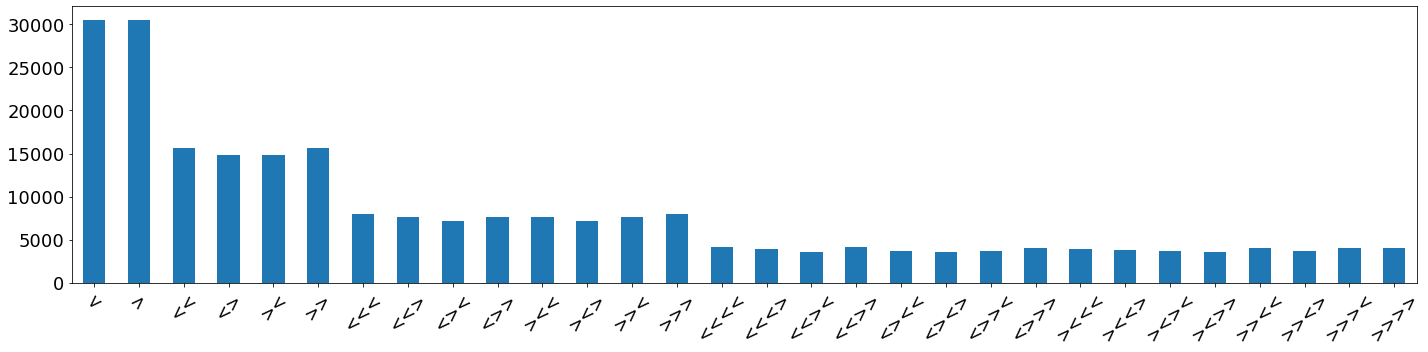

In [125]:
plt.figure(figsize=(20,5))
ctcf_clusters_pattern_counts.sum(0).plot(kind='bar')
plt.xticks(rotation=45)
plt.show()

### Whole-genome analysis of CTCF blocks given various clustering windows

In [126]:
def whole_genome_CTCF_patterns_by_window(ctcfs, from_k, to_k, ws):
    pattern_counts_by_distance = []
    for distance in src.progress(ws):
        ctcf_clusters = cluster_ctcf_sites(ctcfs, distance)
        ctcf_clusters_pattern_counts = get_pattern_count(ctcf_clusters, from_k, to_k).sum(0).to_frame(name=distance)
        pattern_counts_by_distance.append(ctcf_clusters_pattern_counts)

    pattern_counts_by_distance = pd.concat(pattern_counts_by_distance, axis=1).T
    return pattern_counts_by_distance

In [127]:
# from_k, to_k = 1, 4
# pattern_counts_by_distance = whole_genome_CTCF_patterns_by_window(ctcfs, from_k, to_k, ws)
# pattern_counts_by_distance.to_csv("../../data/interim/pattern_counts_by_distance.tsv", sep='\t', index=True, index_label="window", header=True)
# pattern_counts_by_distance.head()

In [128]:
pattern_counts_by_distance = pd.read_csv(src.interim_data_path / "pattern_counts_by_distance.tsv", sep="\t", index_col=0)

In [262]:
# def plot_patterns_by_window_and_size_v(pattern_counts_by_distance, cmap="Blues", mask=None, linecolor='white', cbar=True):
#     fig = plt.figure(figsize=(40, 50), tight_layout=True)
#     gs = GridSpec(5,4, height_ratios=[1,1,1,1,1.5], width_ratios=[3,5,15,35])
#     for i,size in enumerate([1,2,3,4]):
#         patterns = order_by_size[size]#list(filter(lambda x: len(x) == size, pattern_counts_by_distance.columns))
#         for j,ws in enumerate(window_swap):
#             ax = plt.subplot(gs[j,i])
#             vmax = max(pattern_counts_by_distance.loc[ws, patterns].max().max(), 1)
#             if mask is not None:
#                 locmask = mask.loc[ws, patterns]
#             else:
#                 locmask = None
#             ax = sns.heatmap(pattern_counts_by_distance.loc[ws, patterns], linewidths=0.9, 
#                              cmap=cmap, annot=False, vmin=0, vmax=vmax, mask=locmask, linecolor=linecolor,
#                              cbar=cbar)

#             plt.yticks(rotation=0, fontsize=30)
#             plt.xticks(fontsize=25)
            
#             visiblex = True#True if j == 4 else False
#             visibley = True if i == 0 else False
#             plt.setp(ax.get_yticklabels(), visible=visibley)
#             plt.setp(ax.get_xticklabels(), visible=visiblex)
            
#             plt.xlabel("")
#             plt.ylabel("")
#             if cbar:
#                 cbar = ax.collections[0].colorbar
#                 cbar.ax.tick_params(labelsize=30)
#     fig.text(0.5, -0.03, 'CTCF block', ha='center', fontsize=40)
#     fig.text(-0.03, 0.5, 'Clustering window', va='center', rotation='vertical', fontsize=40)
#     return fig


# def plot_patterns_by_window_and_size_h(pattern_counts_by_distance, cmap="Blues", mask=None, linecolor='white', cbar=True):
#     fig = plt.figure(figsize=(50, 40), tight_layout=False)
#     gs = GridSpec(4,5, width_ratios=[1,1,1,1,1.5], height_ratios=[3,5,15,35])
#     for i,size in enumerate([1,2,3,4]):
#         patterns = order_by_size[size]#list(filter(lambda x: len(x) == size, pattern_counts_by_distance.columns))
#         for j,ws in enumerate(window_swap):
#             ax = plt.subplot(gs[i,j])
#             vmax = max(pattern_counts_by_distance.loc[ws, patterns].max().max(), 1)
#             if mask is not None:
#                 locmask = mask.loc[ws, patterns].T
#             else:
#                 locmask = None
#             ax = sns.heatmap(pattern_counts_by_distance.loc[ws, patterns].T, linewidths=0.9, 
#                              cmap=cmap, annot=False, vmin=0, vmax=vmax, mask=locmask, linecolor=linecolor,
#                              cbar=cbar, cbar_kws={'orientation': 'horizontal', 'use_gridspec': True, 'shrink':1})

#             plt.yticks(rotation=0, fontsize=30)
#             plt.xticks(fontsize=25, rotation=45)
            
#             visiblex = True if i == 3 else False
#             visibley = True if j == 0 else False
#             plt.setp(ax.get_yticklabels(), visible=visibley)
#             plt.setp(ax.get_xticklabels(), visible=visiblex)
            
#             plt.xlabel("")
#             plt.ylabel("")
#             if cbar:
#                 cbar = ax.collections[0].colorbar
#                 cbar.ax.tick_params(labelsize=30)
#     fig.text(0.5, -0.03, 'Clustering window', ha='center', fontsize=40)
#     fig.text(-0.03, 0.5, 'CTCF block', va='center', rotation='vertical', fontsize=40)
#     return fig

def normalize_by_number_of_patterns(ctcf_clusters_pattern_counts):
    res = []
    for p in ctcf_clusters_pattern_counts.columns:
        n = (ctcf_clusters_pattern_counts[p]*(2**len(p)))#.map(lambda x: np.log10(x + 1))
        d = 1#ctcf_clusters_pattern_counts.index.map(np.log10) + 1
        r = n/d#np.log10(n/d + 1)
        res.append( r.to_frame(name=p) )
    return pd.concat(res, axis=1)

def normalize_by_window_size(ctcf_clusters_pattern_counts):
    res = []
    for p in ctcf_clusters_pattern_counts.columns:
        n = ctcf_clusters_pattern_counts[p]
        d = ctcf_clusters_pattern_counts.index.map(np.log10) + 1
        r = n/d#np.log10(n/d + 1)
        res.append( r.to_frame(name=p) )
    return pd.concat(res, axis=1)


patternclass_to_pattern = {
    'Same': ['>>', '<<', '>>>', '<<<', '>>>', '>>>>', '<<<<'],
    'Convergent': ['><', '>><', '><<', '>><<', '>>><', '><<<'],
    'Divergent': ['<>', '<>>', '<<>', '<<>>', '<<<>', '<>>>'],
    'Convergent-Divergent': ['><>', '<><', '>><>', '><>>', '<><<', '<<><', '><><', '><<>', '<>><', '<><>']
}


def plot_patterns_by_window_and_class_h(pattern_counts_by_distance, cmap="Blues", mask=None, linecolor='white', cbar=True, cbar_label=''):
    fig = plt.figure(figsize=(60, 30), tight_layout=True)
    
    height_ratios=[
        len(patternclass_to_pattern['Same']),
        len(patternclass_to_pattern['Convergent']),
        len(patternclass_to_pattern['Divergent']),
        len(patternclass_to_pattern['Convergent-Divergent'])
    ]
    
    gs = GridSpec(4,1, height_ratios=height_ratios)
    for i,pclass in enumerate(patternclass_to_pattern.keys()):
        patterns = patternclass_to_pattern[pclass]
        ax = plt.subplot(gs[i])
        if mask is not None:
            locmask = mask.loc[ws, patterns].T
        else:
            locmask = None
        data = pattern_counts_by_distance.loc[ws, patterns].T
        ax = sns.heatmap(data, linewidths=0.9,
                         cmap=cmap, annot=False, mask=locmask, linecolor=linecolor,
                         cbar=cbar, cbar_kws={'label': cbar_label})

        plt.yticks(rotation=0, fontsize=60)
        plt.xticks(fontsize=60, rotation=45)
            
        visiblex = True if i == 3 else False
        plt.setp(ax.get_xticklabels(), visible=visiblex)
        plt.xlabel("")
        plt.ylabel(pclass.replace("-",'/\n/') + "\n", fontsize=60)
        if cbar:
            cbar = ax.collections[0].colorbar
            cbar.ax.tick_params(labelsize=30)
            cbar.ax.yaxis.label.set_size(50)
    fig.text(0.5, -0.03, 'Clustering window', ha='center', fontsize=40)
#     fig.text(-0.03, 0.5, 'CTCF block', va='center', rotation='vertical', fontsize=40)
    return fig


def plot_patterns_by_window_and_size_h(pattern_counts_by_distance, cmap="Blues", mask=None, linecolor='white', cbar=True, cbar_label=''):
    fig = plt.figure(figsize=(60, 30), tight_layout=True)
    gs = GridSpec(3,1, height_ratios=[1,2,3])
    for i,size in enumerate([2,3,4]):
        patterns = order_by_size[size]#list(filter(lambda x: len(x) == size, pattern_counts_by_distance.columns))
        ax = plt.subplot(gs[i])
        if mask is not None:
            locmask = mask.loc[ws, patterns].T
        else:
            locmask = None
        data = pattern_counts_by_distance.loc[ws, patterns].T
        ax = sns.heatmap(data, linewidths=0.9,
                         cmap=cmap, annot=False, mask=locmask, linecolor=linecolor,
                         cbar=cbar, cbar_kws={'label': cbar_label})

        plt.yticks(rotation=0, fontsize=40)
        plt.xticks(fontsize=40, rotation=45)
            
        visiblex = True if size == 4 else False
        plt.setp(ax.get_xticklabels(), visible=visiblex)
        plt.xlabel("")
        plt.ylabel("")
        if cbar:
            cbar = ax.collections[0].colorbar
            cbar.ax.tick_params(labelsize=30)
            cbar.ax.yaxis.label.set_size(50)
    fig.text(0.5, -0.03, 'Clustering window', ha='center', fontsize=40)
    fig.text(-0.03, 0.5, 'CTCF block', va='center', rotation='vertical', fontsize=40)
    return fig
    
    


order_by_size = {
    1: ['>', '<'],
    2: ['>>', '<<', '><', '<>'],
    3: ['>>>', '<<<', '>><', '><<', '<>>', '<<>', '><>', '<><'],
    4: ['>>>>', '<<<<', 
        '>>><', '><<<', 
        '>><<', 
        '<<<>', '<>>>', 
        '<<>>', 
        '><>>', '<<><', 
        '>><>', '<><<', 
        '><><', '<><>',
        '<>><', '><<>']
}
    

#### Plotting the number of every CTCF block type for every block size

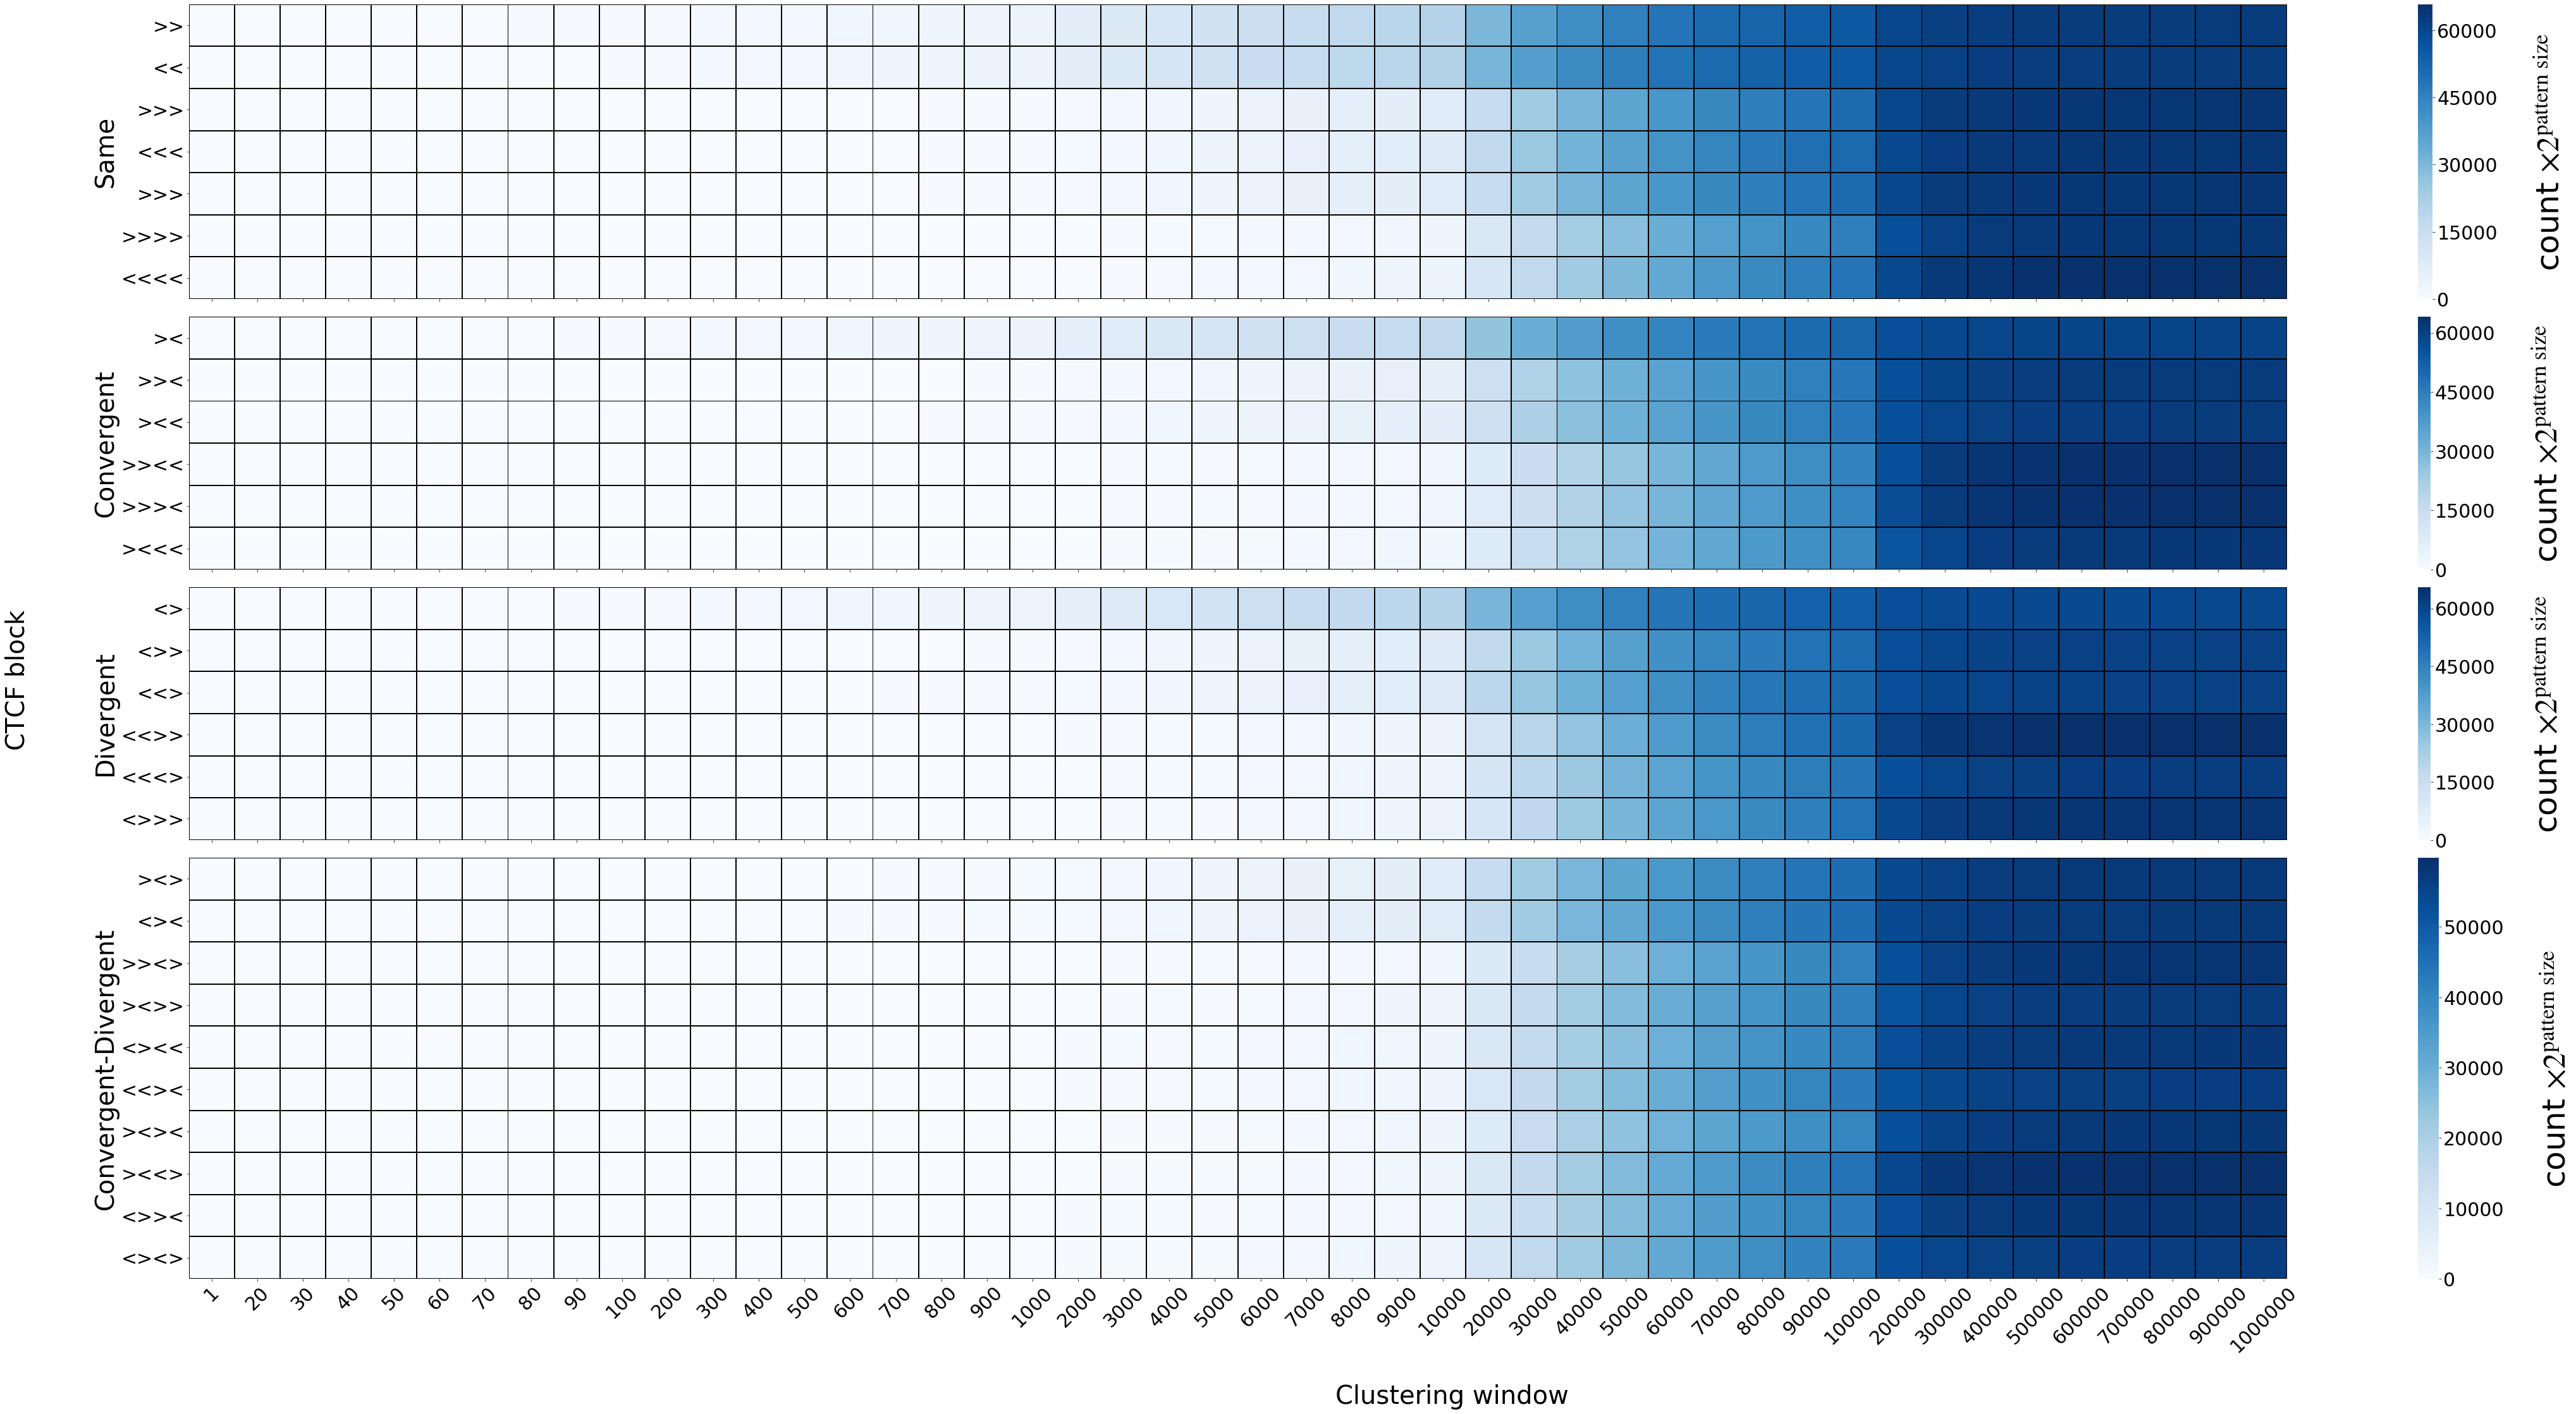

In [133]:
fig = plot_patterns_by_window_and_class_h(normalize_by_number_of_patterns(pattern_counts_by_distance), cmap="Blues", linecolor='black', cbar_label="\n" + r"count $\times 2^{\mathrm{pattern\ size}}$")
fig.show()
fig.savefig(figure_path / "pattern_counts_by_distance.pdf", bbox_inches='tight', transparent=True)

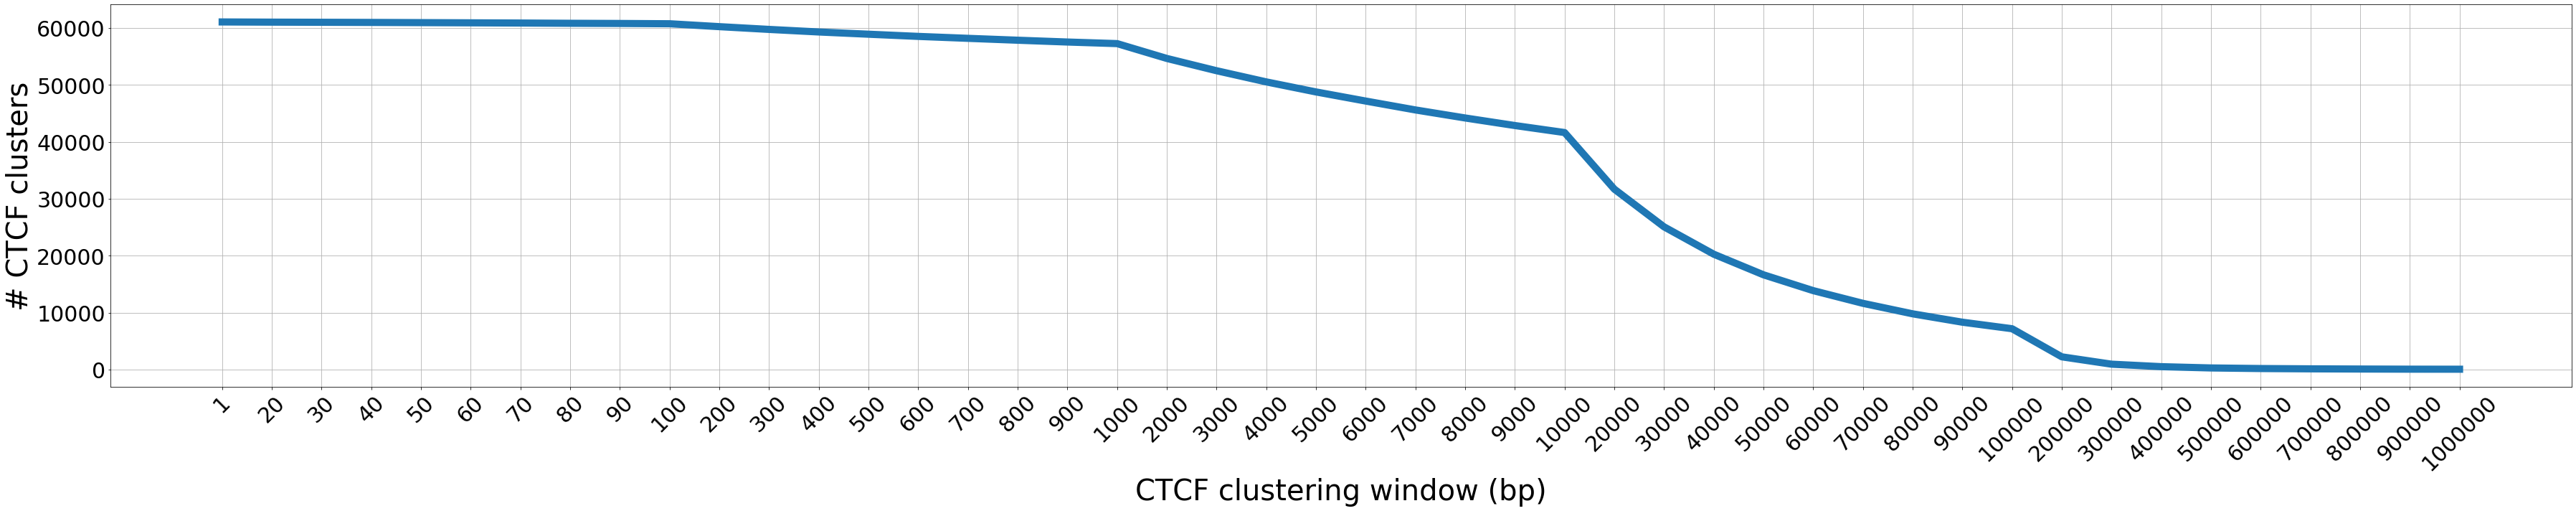

In [134]:
plt.figure(figsize=(50, 10), tight_layout=True)
plt.plot(all_clusters[list(map(str, ws))].nunique(), linewidth=10)
plt.grid()
xticks, _ = plt.xticks()
plt.xticks(xticks, labels=ws)
plt.xlabel("CTCF clustering window (bp)", fontsize=40)
plt.ylabel("# CTCF clusters", fontsize=40)
plt.yticks(rotation=0, fontsize=30)
plt.xticks(fontsize=30, rotation=45)
plt.show()

### Statistical assessment of the CTCF block significance
We run a binomial test for every CTCF block and clustering window to understand if a block is significant in a specific clustering window. The test is done as follows:

Given the pattern $p$ of size $l$ and a clustering window $w$, we call the number of $p$ found with $w$ equal to $c_{pw}$. The null probability to find $p$ is $\frac{1}{2^{l}}$, the number of successes is $c_{pw}$ and the number of trials is $\sum_{p'\in P_l} c_{p'w}$ where $P_l$ is the set of possible CTCF blocks having the same size $l$ as $p$.

In [209]:

def get_binomial_pvalues(pattern_counts_by_distance, alternative='greater', significance_level = 0.2):
    pattern_pvalue_by_distance = pd.DataFrame(index=pattern_counts_by_distance.index, columns=pattern_counts_by_distance.columns, dtype=float)
    for pattern in src.progress(pattern_counts_by_distance.columns):
        pattern_size = len(pattern)
        all_pattern_with_same_size = list(filter(lambda x: len(x) == pattern_size, pattern_counts_by_distance.columns))
        for window in pattern_counts_by_distance.index:
            if alternative == 'both':
                greater_pvalue = binom_test(x=pattern_counts_by_distance.loc[window, pattern], 
                                            p=1/(2**pattern_size), 
                                            n=pattern_counts_by_distance.loc[window, all_pattern_with_same_size].sum(), 
                                            alternative='greater')
                
                less_pvalue = binom_test(x=pattern_counts_by_distance.loc[window, pattern], 
                                         p=1/(2**pattern_size), 
                                         n=pattern_counts_by_distance.loc[window, all_pattern_with_same_size].sum(), 
                                         alternative='less')
                
                if greater_pvalue <= significance_level:
                    pvalue = 1 - greater_pvalue
                elif less_pvalue <= significance_level:
                    pvalue = -(1 - less_pvalue)
                else:
                    pvalue = 0
            else:
                pvalue = binom_test(x=pattern_counts_by_distance.loc[window, pattern], p=1/(2**pattern_size), n=pattern_counts_by_distance.loc[window, all_pattern_with_same_size].sum(), 
                                    alternative=alternative)
            pattern_pvalue_by_distance.loc[window, pattern] = pvalue
    return pattern_pvalue_by_distance

In [281]:
pattern_both_pvalue_by_distance = get_binomial_pvalues(pattern_counts_by_distance, alternative='both', significance_level=0.2)
pattern_both_pvalue_by_distance.head()

<    >        <<        <>        ><        >>  <<<  <<>  <><  <>>  \
window                                                                         
1       0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0   
20      0.0  0.0 -0.916533 -0.831611  0.000000  0.953860  0.0  0.0  0.0  0.0   
30      0.0  0.0  0.000000 -0.954833  0.851408  0.000000  0.0  0.0  0.0  0.0   
40      0.0  0.0  0.000000 -0.963725  0.000000  0.000000  0.0  0.0  0.0  0.0   
50      0.0  0.0  0.000000 -0.967014  0.829138  0.829138  0.0  0.0  0.0  0.0   

        ...  <>><  <>>>  ><<<  ><<>  ><><  ><>>  >><<  >><>  >>><  >>>>  
window  ...                                                              
1       ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
20      ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
30      ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
40      ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
50      ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 30 columns]

In [282]:
pattern_greater_pvalue_by_distance = get_binomial_pvalues(pattern_counts_by_distance, alternative='greater')
pattern_less_pvalue_by_distance = get_binomial_pvalues(pattern_counts_by_distance, alternative='less')
pattern_pvalue_by_distance.head()

<         >        <<        <>        ><        >>  <<<  <<>  \
window                                                                         
1       0.567472  0.435712  0.578125  1.000000  0.578125  0.578125  1.0  1.0   
20      0.567472  0.435712  0.965843  0.916533  0.274863  0.046140  1.0  1.0   
30      0.567472  0.435712  0.665089  0.978785  0.148592  0.224738  1.0  1.0   
40      0.567472  0.435712  0.394228  0.980805  0.303852  0.224774  1.0  1.0   
50      0.567472  0.435712  0.617929  0.980656  0.170862  0.170862  1.0  1.0   

        <><  <>>  ...  <>><  <>>>  ><<<  ><<>  ><><  ><>>  >><<  >><>  >>><  \
window            ...                                                         
1       1.0  1.0  ...   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
20      1.0  1.0  ...   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
30      1.0  1.0  ...   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
40      1.0  1.0  ...   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
50      1.0  1.0  ...   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   

        >>>>  
window        
1        1.0  
20       1.0  
30       1.0  
40       1.0  
50       1.0  

[5 rows x 30 columns]

In [283]:
cm_reds = plt.cm.get_cmap("Reds", 128)
cm_blues = plt.cm.get_cmap("Blues_r", 128)

newcolors = np.vstack((cm_blues(np.linspace(0, 1, 128)),
                       np.zeros((400, 4)),
                       cm_reds(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='mia')
newcmp

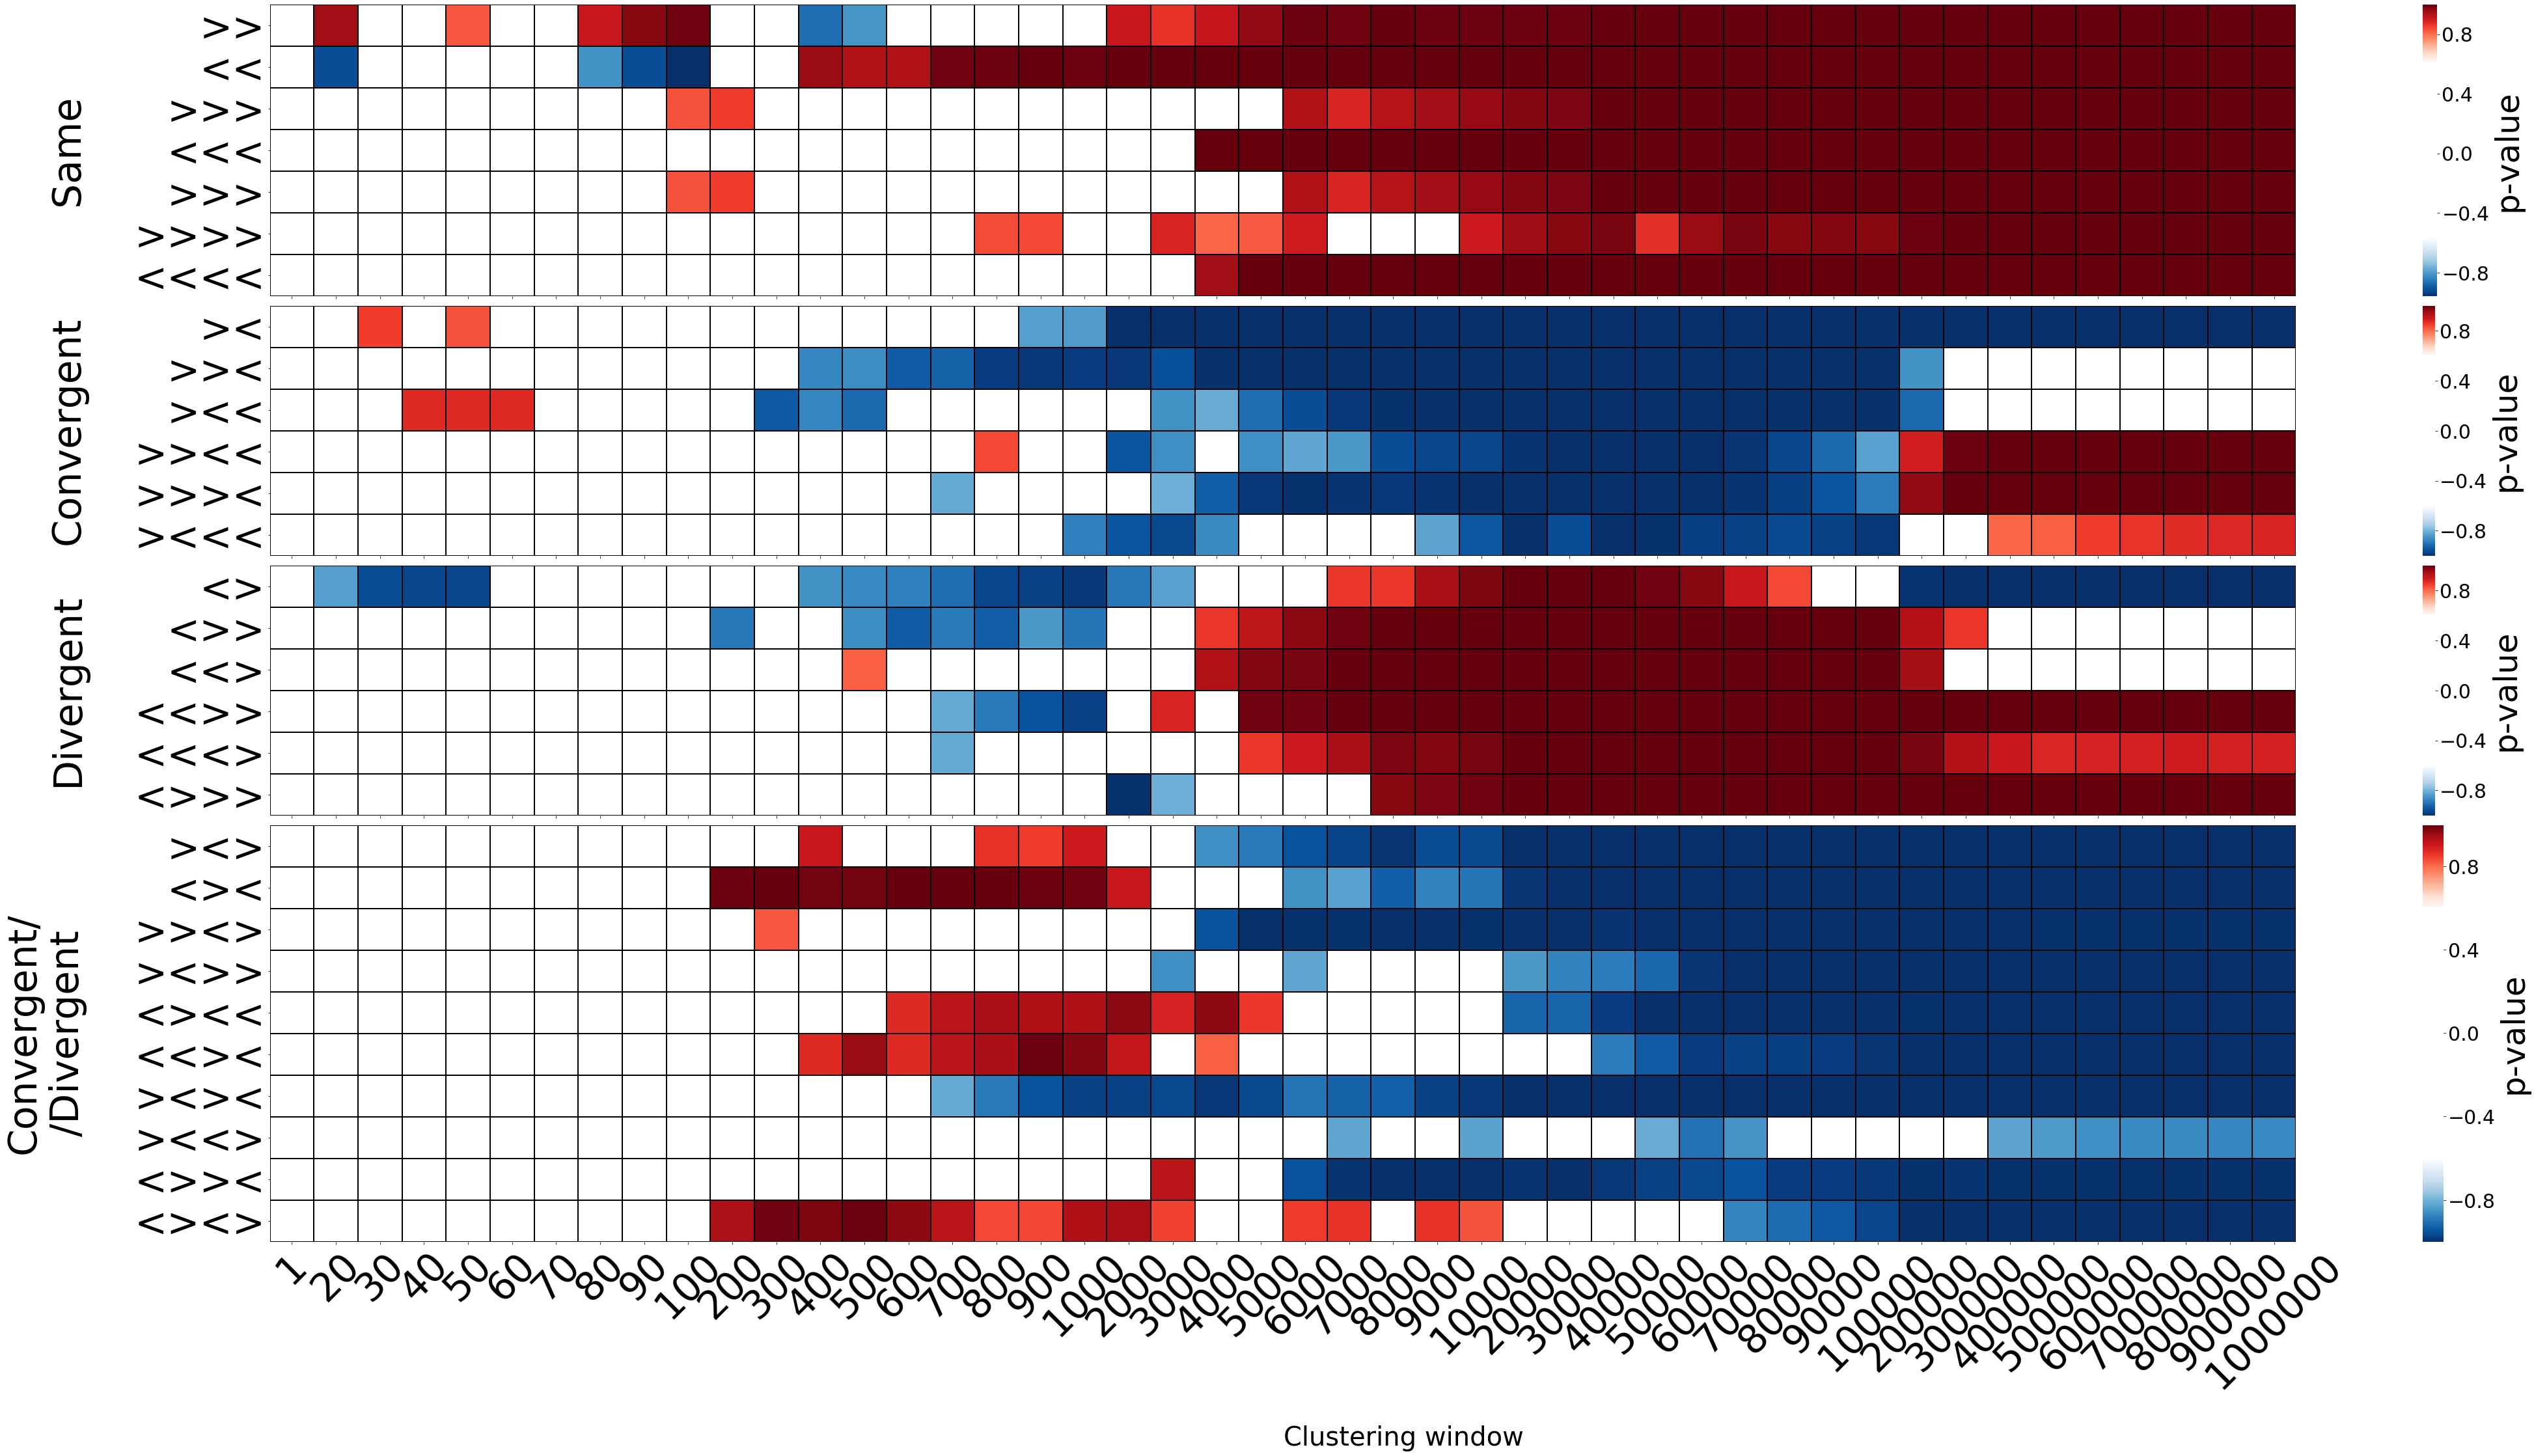

In [284]:
fig = plot_patterns_by_window_and_class_h(pattern_both_pvalue_by_distance, 
                                 cmap=newcmp, 
                                 mask=None, #pattern_pvalue_by_distance >= significance_level, 
                                 linecolor='black', 
                                 cbar=True, cbar_label="p-value")
fig.show()
fig.savefig(figure_path / "pattern_pvalues_by_distance.pdf", bbox_inches='tight', transparent=True)

# Sensitivity analysis by removing low-score CTCF sites

In [285]:
ctcfs_with_scores = pd.read_csv(src.interim_data_path / "ctcf_scores.tsv", sep='\t')
ctcfs_with_scores.head()

chr   start     end orientation  ctcf_id  MotifScore  ChipSeqScore  \
0  chr1  237593  237953           >        0    9.790746     12.637052   
1  chr1  521337  521697           >        1   10.259412     13.835230   
2  chr1  714087  714447           >        2    9.893988      9.332479   
3  chr1  805232  805362           >        3   14.365820     46.633221   
4  chr1  839966  840326           >        4   16.393501     60.461779   

   rank_score_aggregate  
0          1.392043e+09  
1          1.563464e+09  
2          1.241503e+09  
3          3.272974e+09  
4          3.574601e+09

In [286]:
q25_rank_score = ctcfs_with_scores.rank_score_aggregate.quantile(0.25)
q50_rank_score = ctcfs_with_scores.rank_score_aggregate.quantile(0.50)
q75_rank_score = ctcfs_with_scores.rank_score_aggregate.quantile(0.75)
print("0.25 quantile: ", q25_rank_score)
print("0.50 quantile: ", q50_rank_score)
print("0.75 quantile: ", q75_rank_score)

0.25 quantile:  218828810.5
0.50 quantile:  790528315.0
0.75 quantile:  1791961997.0


In [287]:
ctcfs_greater_25q = ctcfs_with_scores.loc[ctcfs_with_scores.rank_score_aggregate > q25_rank_score, ctcfs.columns.tolist()]
ctcfs_greater_50q = ctcfs_with_scores.loc[ctcfs_with_scores.rank_score_aggregate > q50_rank_score, ctcfs.columns.tolist()]
ctcfs_greater_75q = ctcfs_with_scores.loc[ctcfs_with_scores.rank_score_aggregate > q75_rank_score, ctcfs.columns.tolist()]

ctcfs_lower_25q = ctcfs_with_scores.loc[ctcfs_with_scores.rank_score_aggregate < q25_rank_score, ctcfs.columns.tolist()]
ctcfs_lower_50q = ctcfs_with_scores.loc[ctcfs_with_scores.rank_score_aggregate < q50_rank_score, ctcfs.columns.tolist()]
ctcfs_lower_75q = ctcfs_with_scores.loc[ctcfs_with_scores.rank_score_aggregate < q75_rank_score, ctcfs.columns.tolist()]

In [288]:
# ctcfs_greater_25q_patterns = whole_genome_CTCF_patterns_by_window(ctcfs_greater_25q, from_k, to_k, ws)
# ctcfs_greater_25q_patterns.to_csv("../../data/interim/ctcfs_greater_25q_patterns_counts_by_distance.tsv", sep='\t', index=True, index_label="window", header=True)
# ctcfs_greater_25q_pvalues = get_binomial_pvalues(ctcfs_greater_25q_patterns)

# ctcfs_greater_50q_patterns = whole_genome_CTCF_patterns_by_window(ctcfs_greater_50q, from_k, to_k, ws)
# ctcfs_greater_50q_patterns.to_csv("../../data/interim/ctcfs_greater_50q_patterns_counts_by_distance.tsv", sep='\t', index=True, index_label="window", header=True)
# ctcfs_greater_50q_pvalues = get_binomial_pvalues(ctcfs_greater_50q_patterns)

# ctcfs_greater_75q_patterns = whole_genome_CTCF_patterns_by_window(ctcfs_greater_75q, from_k, to_k, ws)
# ctcfs_greater_75q_patterns.to_csv("../../data/interim/ctcfs_greater_75q_patterns_counts_by_distance.tsv", sep='\t', index=True, index_label="window", header=True)
# ctcfs_greater_75q_pvalues = get_binomial_pvalues(ctcfs_greater_75q_patterns)



# ctcfs_lower_25q_patterns = whole_genome_CTCF_patterns_by_window(ctcfs_lower_25q, from_k, to_k, ws)
# ctcfs_lower_25q_patterns.to_csv("../../data/interim/ctcfs_lower_25q_patterns_counts_by_distance.tsv", sep='\t', index=True, index_label="window", header=True)
# ctcfs_lower_25q_pvalues = get_binomial_pvalues(ctcfs_lower_25q_patterns)

# ctcfs_lower_50q_patterns = whole_genome_CTCF_patterns_by_window(ctcfs_lower_50q, from_k, to_k, ws)
# ctcfs_lower_50q_patterns.to_csv("../../data/interim/ctcfs_lower_50q_patterns_counts_by_distance.tsv", sep='\t', index=True, index_label="window", header=True)
# ctcfs_lower_50q_pvalues = get_binomial_pvalues(ctcfs_lower_50q_patterns)

# ctcfs_lower_75q_patterns = whole_genome_CTCF_patterns_by_window(ctcfs_lower_75q, from_k, to_k, ws)
# ctcfs_lower_75q_patterns.to_csv("../../data/interim/ctcfs_lower_75q_patterns_counts_by_distance.tsv", sep='\t', index=True, index_label="window", header=True)
# ctcfs_lower_75q_pvalues = get_binomial_pvalues(ctcfs_lower_75q_patterns)

In [290]:
ctcfs_greater_25q_patterns = pd.read_csv(src.interim_data_path / "ctcfs_greater_25q_patterns_counts_by_distance.tsv", sep='\t', index_col=0)
ctcfs_greater_25q_pvalues = get_binomial_pvalues(ctcfs_greater_25q_patterns, alternative='both', significance_level=0.2)
ctcfs_greater_50q_patterns = pd.read_csv(src.interim_data_path / "ctcfs_greater_50q_patterns_counts_by_distance.tsv", sep='\t', index_col=0)
ctcfs_greater_50q_pvalues = get_binomial_pvalues(ctcfs_greater_50q_patterns, alternative='both', significance_level=0.2)
ctcfs_greater_75q_patterns = pd.read_csv(src.interim_data_path / "ctcfs_greater_75q_patterns_counts_by_distance.tsv", sep='\t', index_col=0)
ctcfs_greater_75q_pvalues = get_binomial_pvalues(ctcfs_greater_75q_patterns, alternative='both', significance_level=0.2)

ctcfs_lower_25q_patterns = pd.read_csv(src.interim_data_path / "ctcfs_lower_25q_patterns_counts_by_distance.tsv", sep='\t', index_col=0)
ctcfs_lower_25q_pvalues = get_binomial_pvalues(ctcfs_lower_25q_patterns, alternative='both', significance_level=0.2)
ctcfs_lower_50q_patterns = pd.read_csv(src.interim_data_path / "ctcfs_lower_50q_patterns_counts_by_distance.tsv", sep='\t', index_col=0)
ctcfs_lower_50q_pvalues = get_binomial_pvalues(ctcfs_lower_50q_patterns, alternative='both', significance_level=0.2)
ctcfs_lower_75q_patterns = pd.read_csv(src.interim_data_path / "ctcfs_lower_75q_patterns_counts_by_distance.tsv", sep='\t', index_col=0)
ctcfs_lower_75q_pvalues = get_binomial_pvalues(ctcfs_lower_75q_patterns, alternative='both', significance_level=0.2)

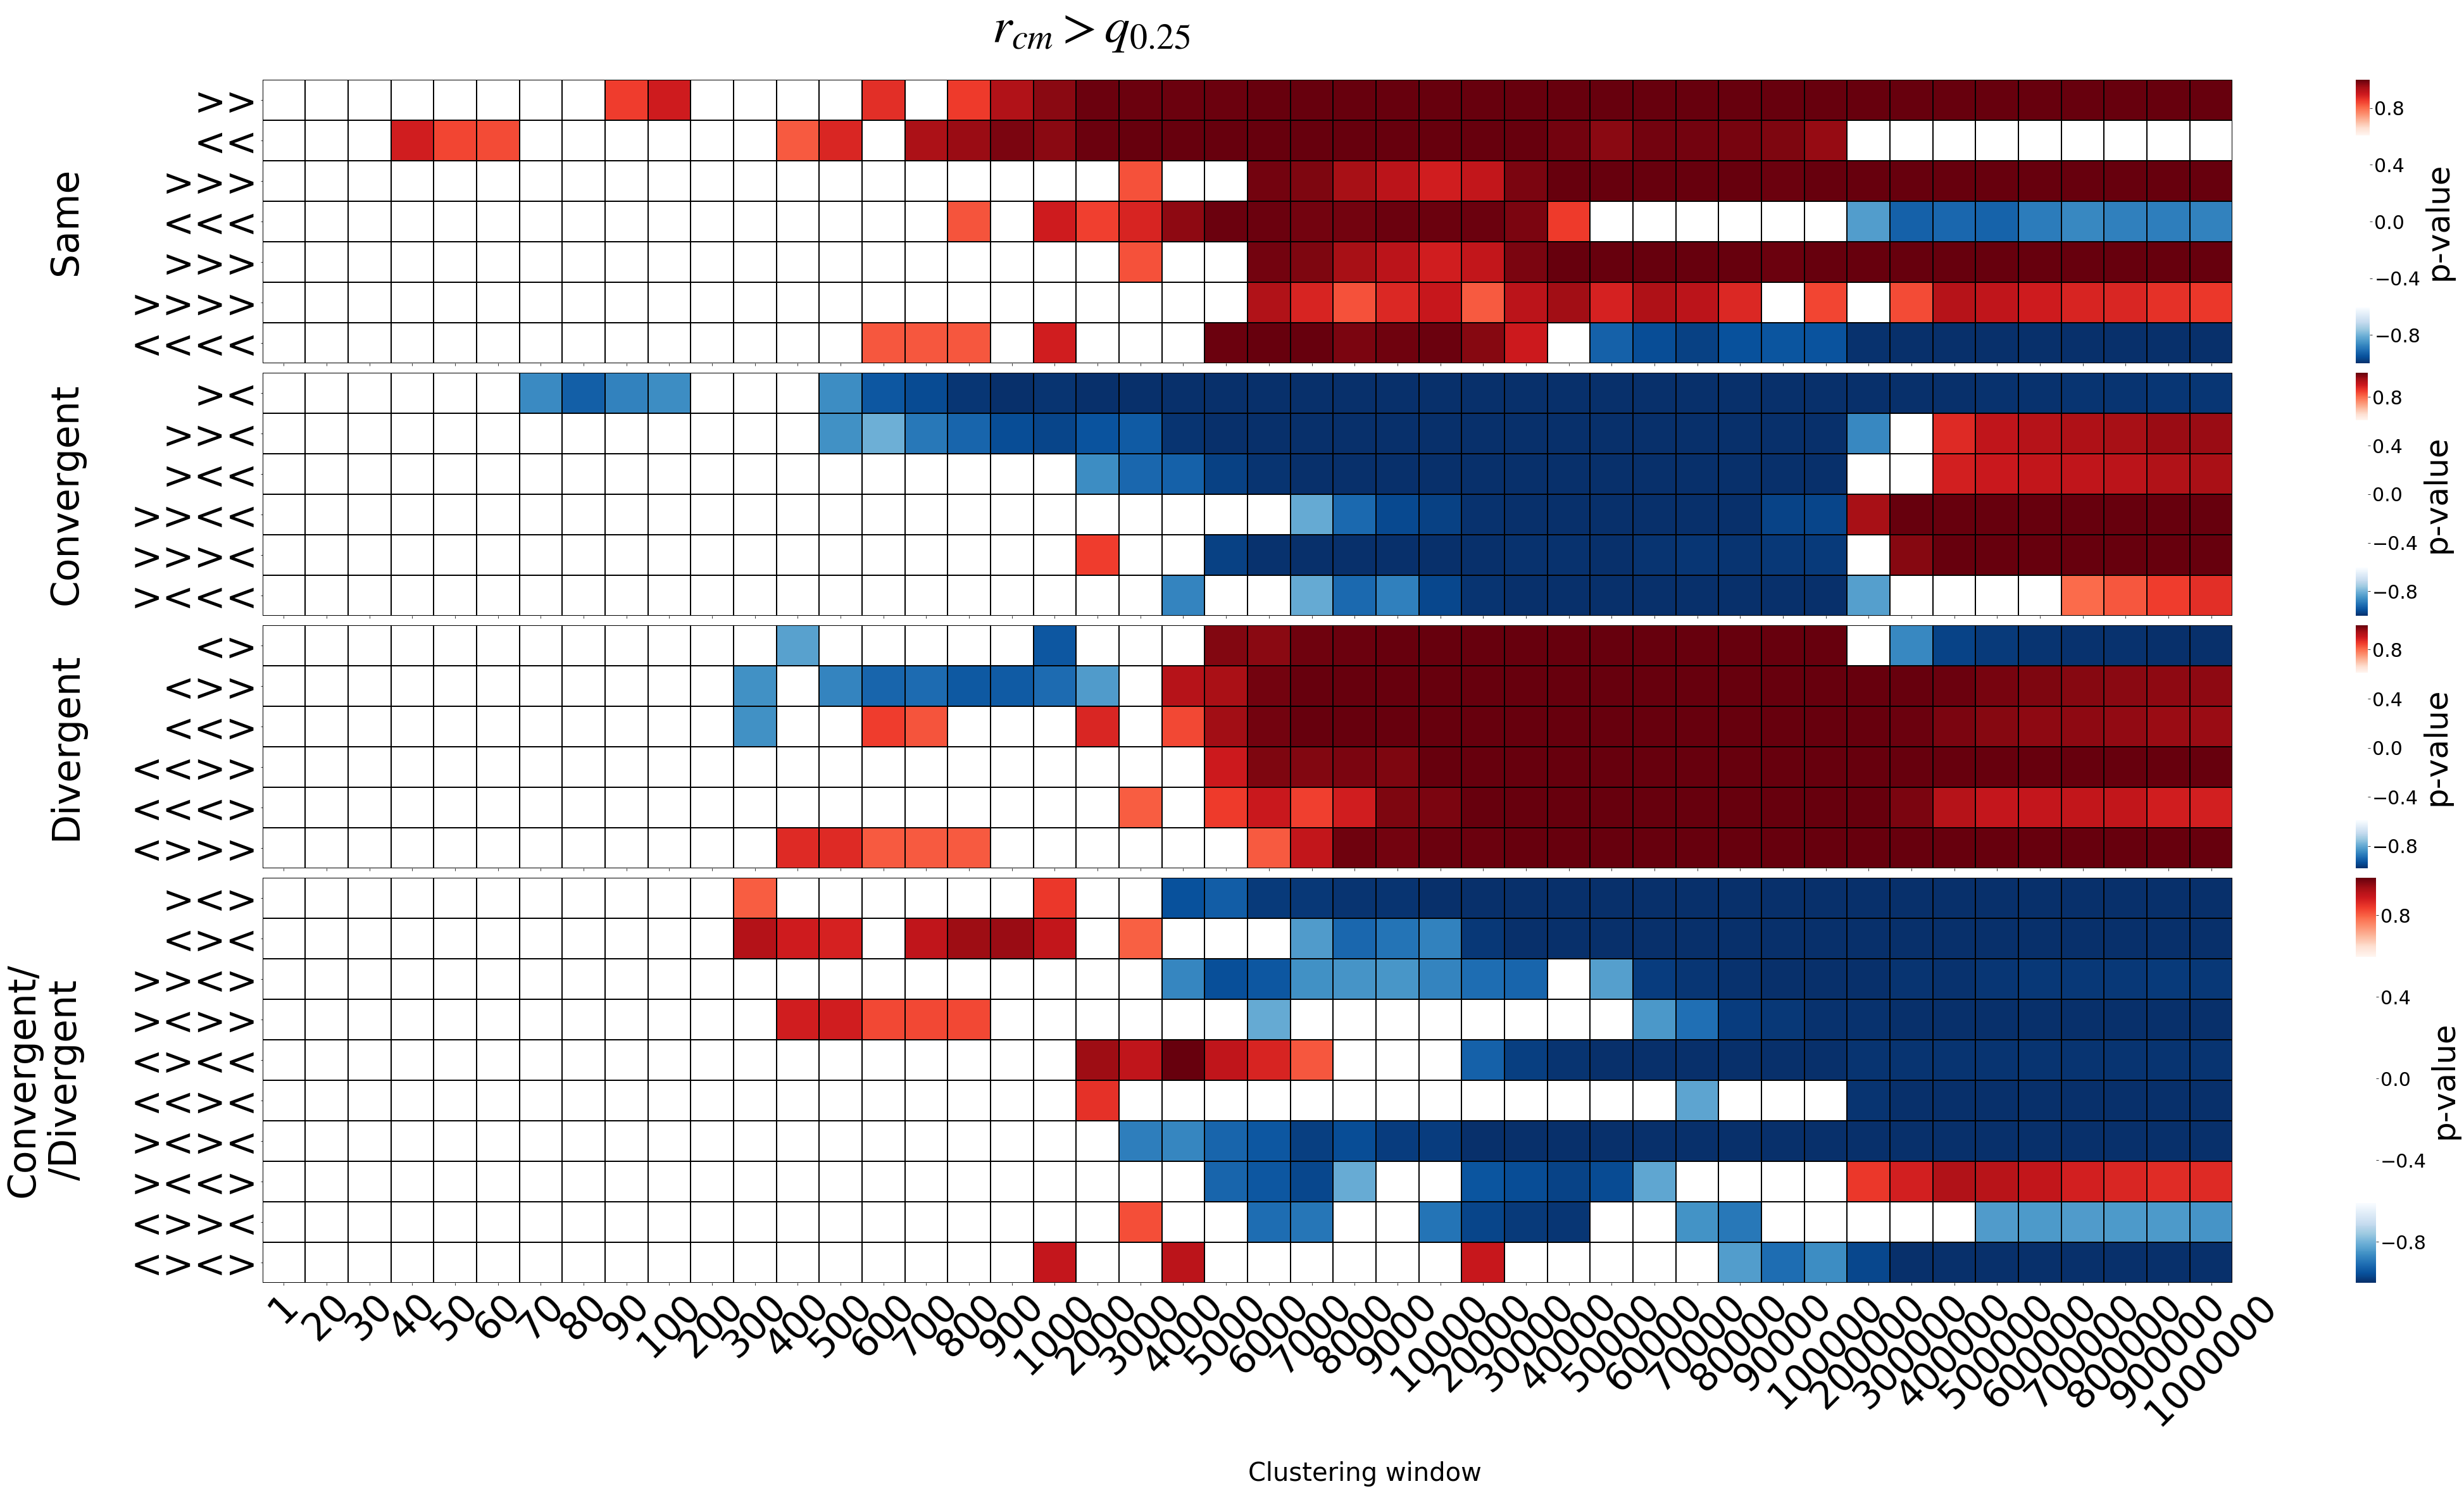

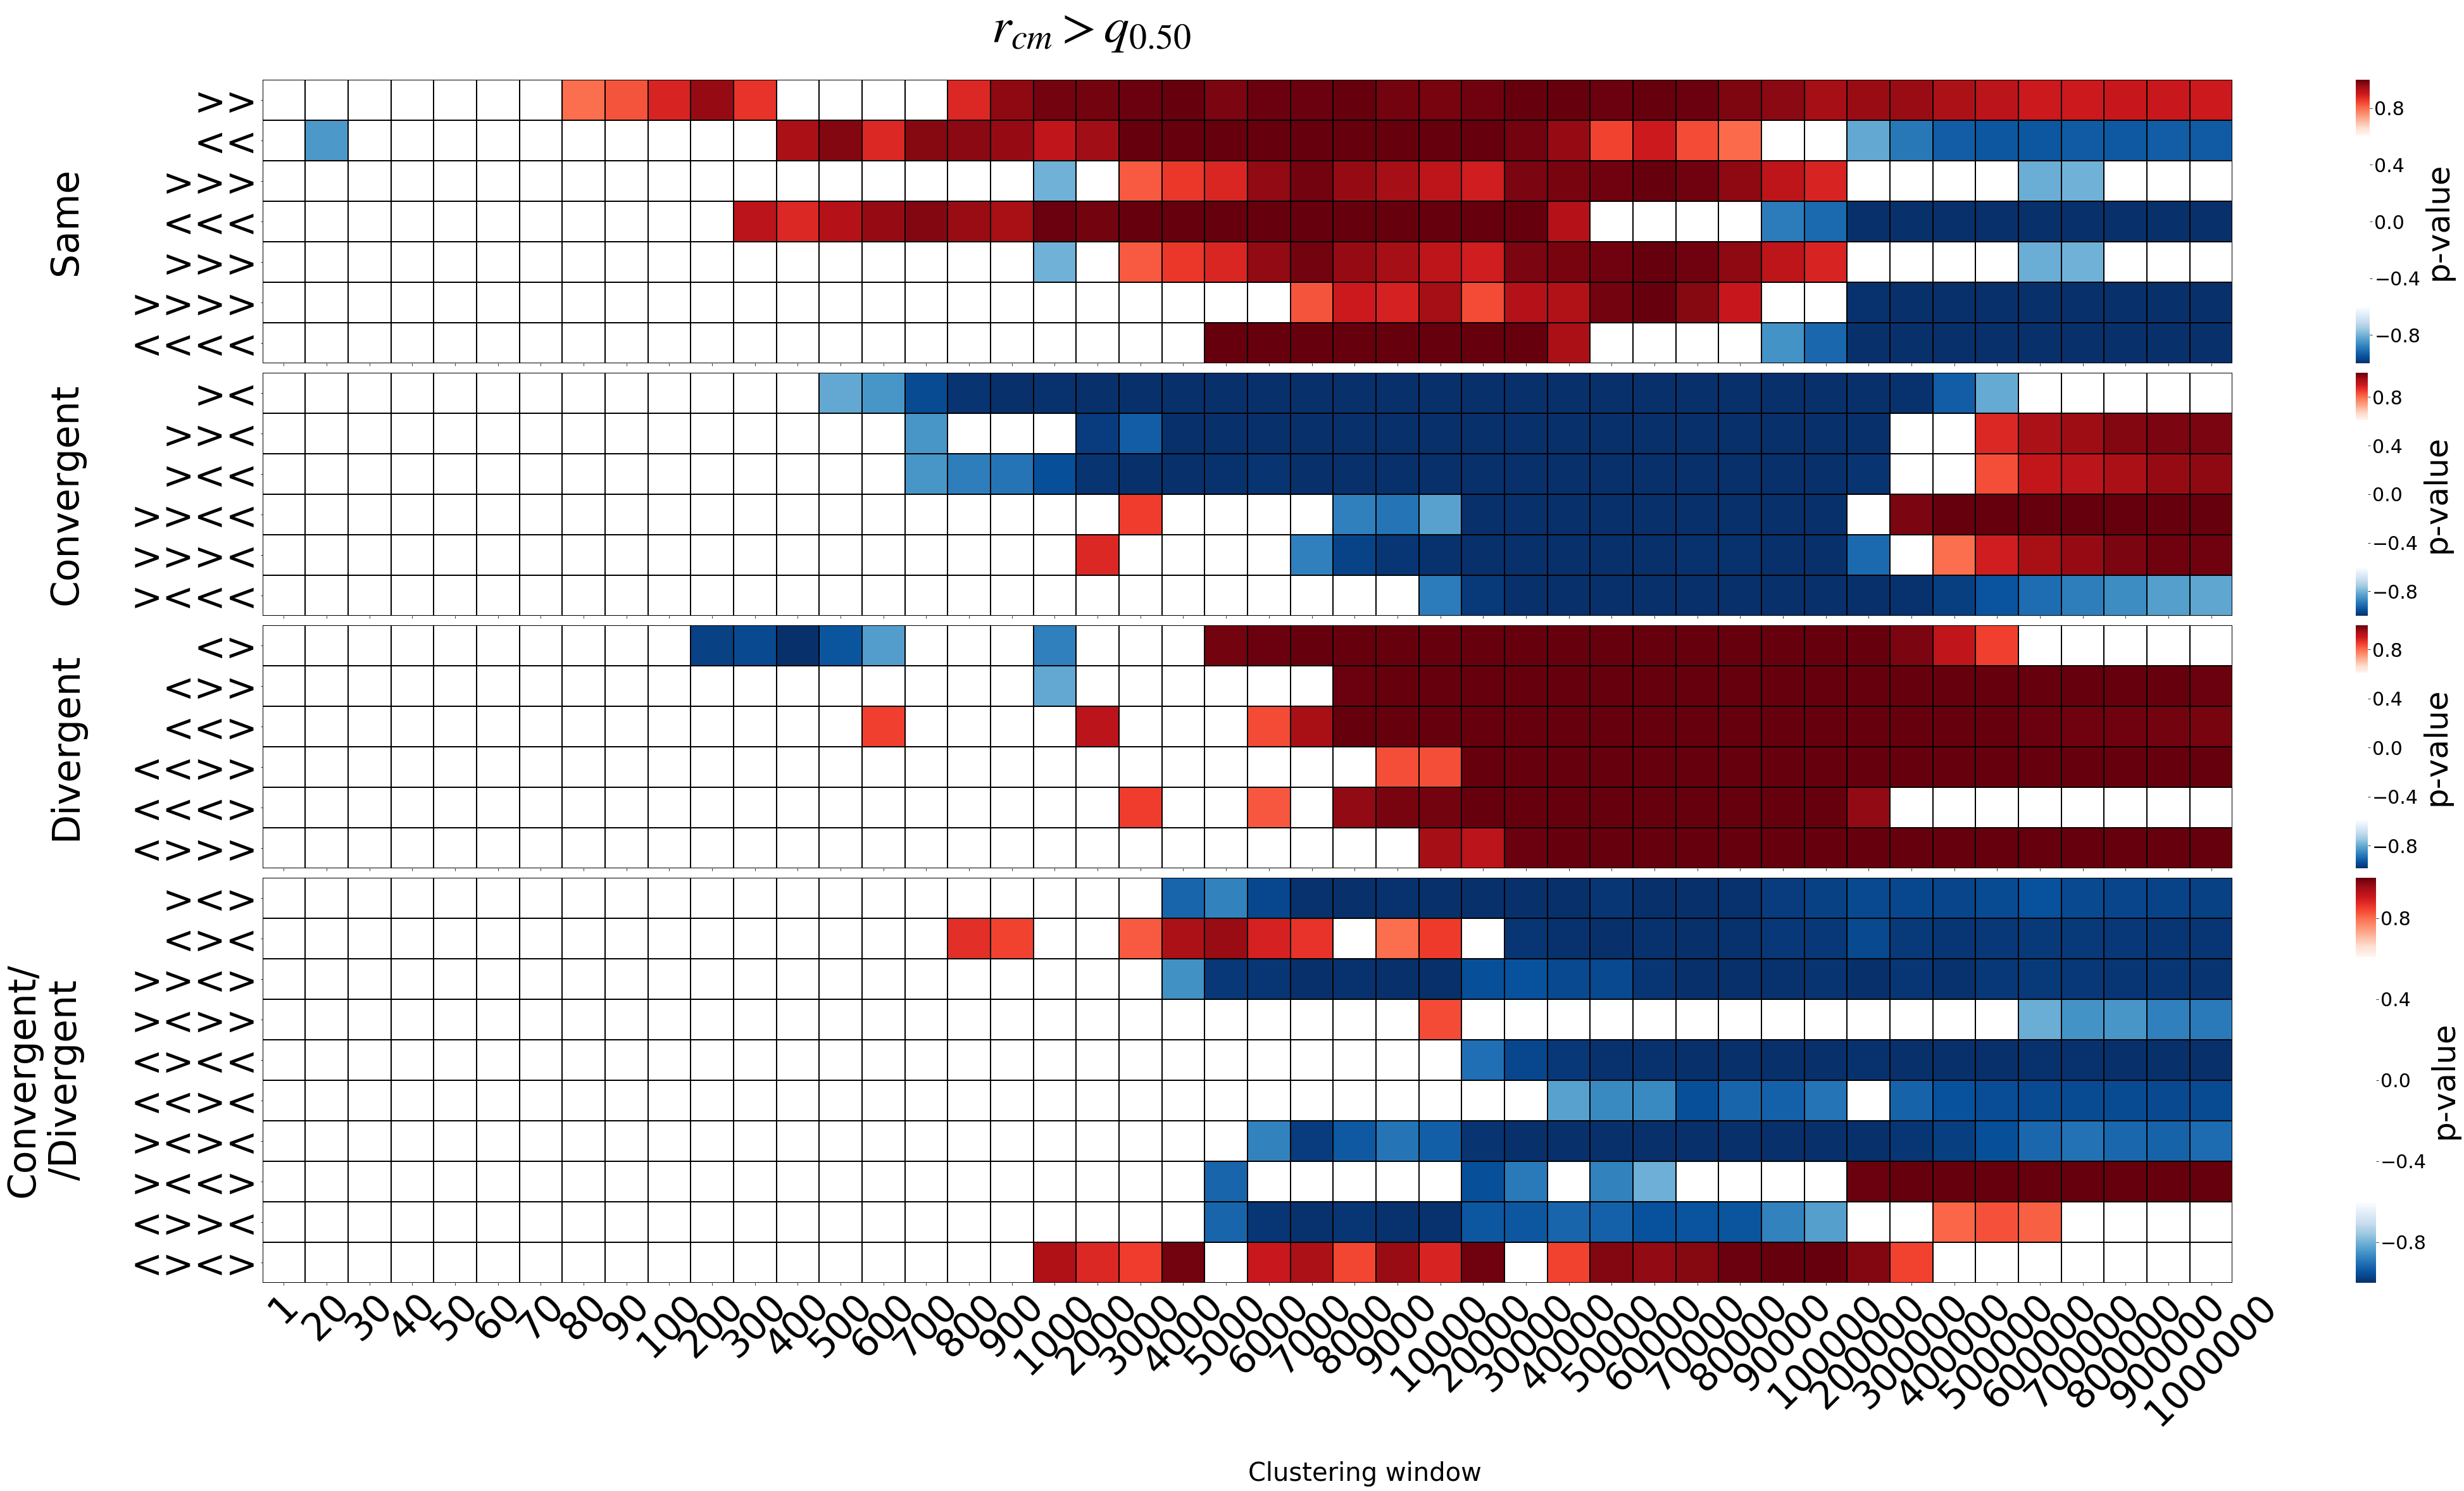

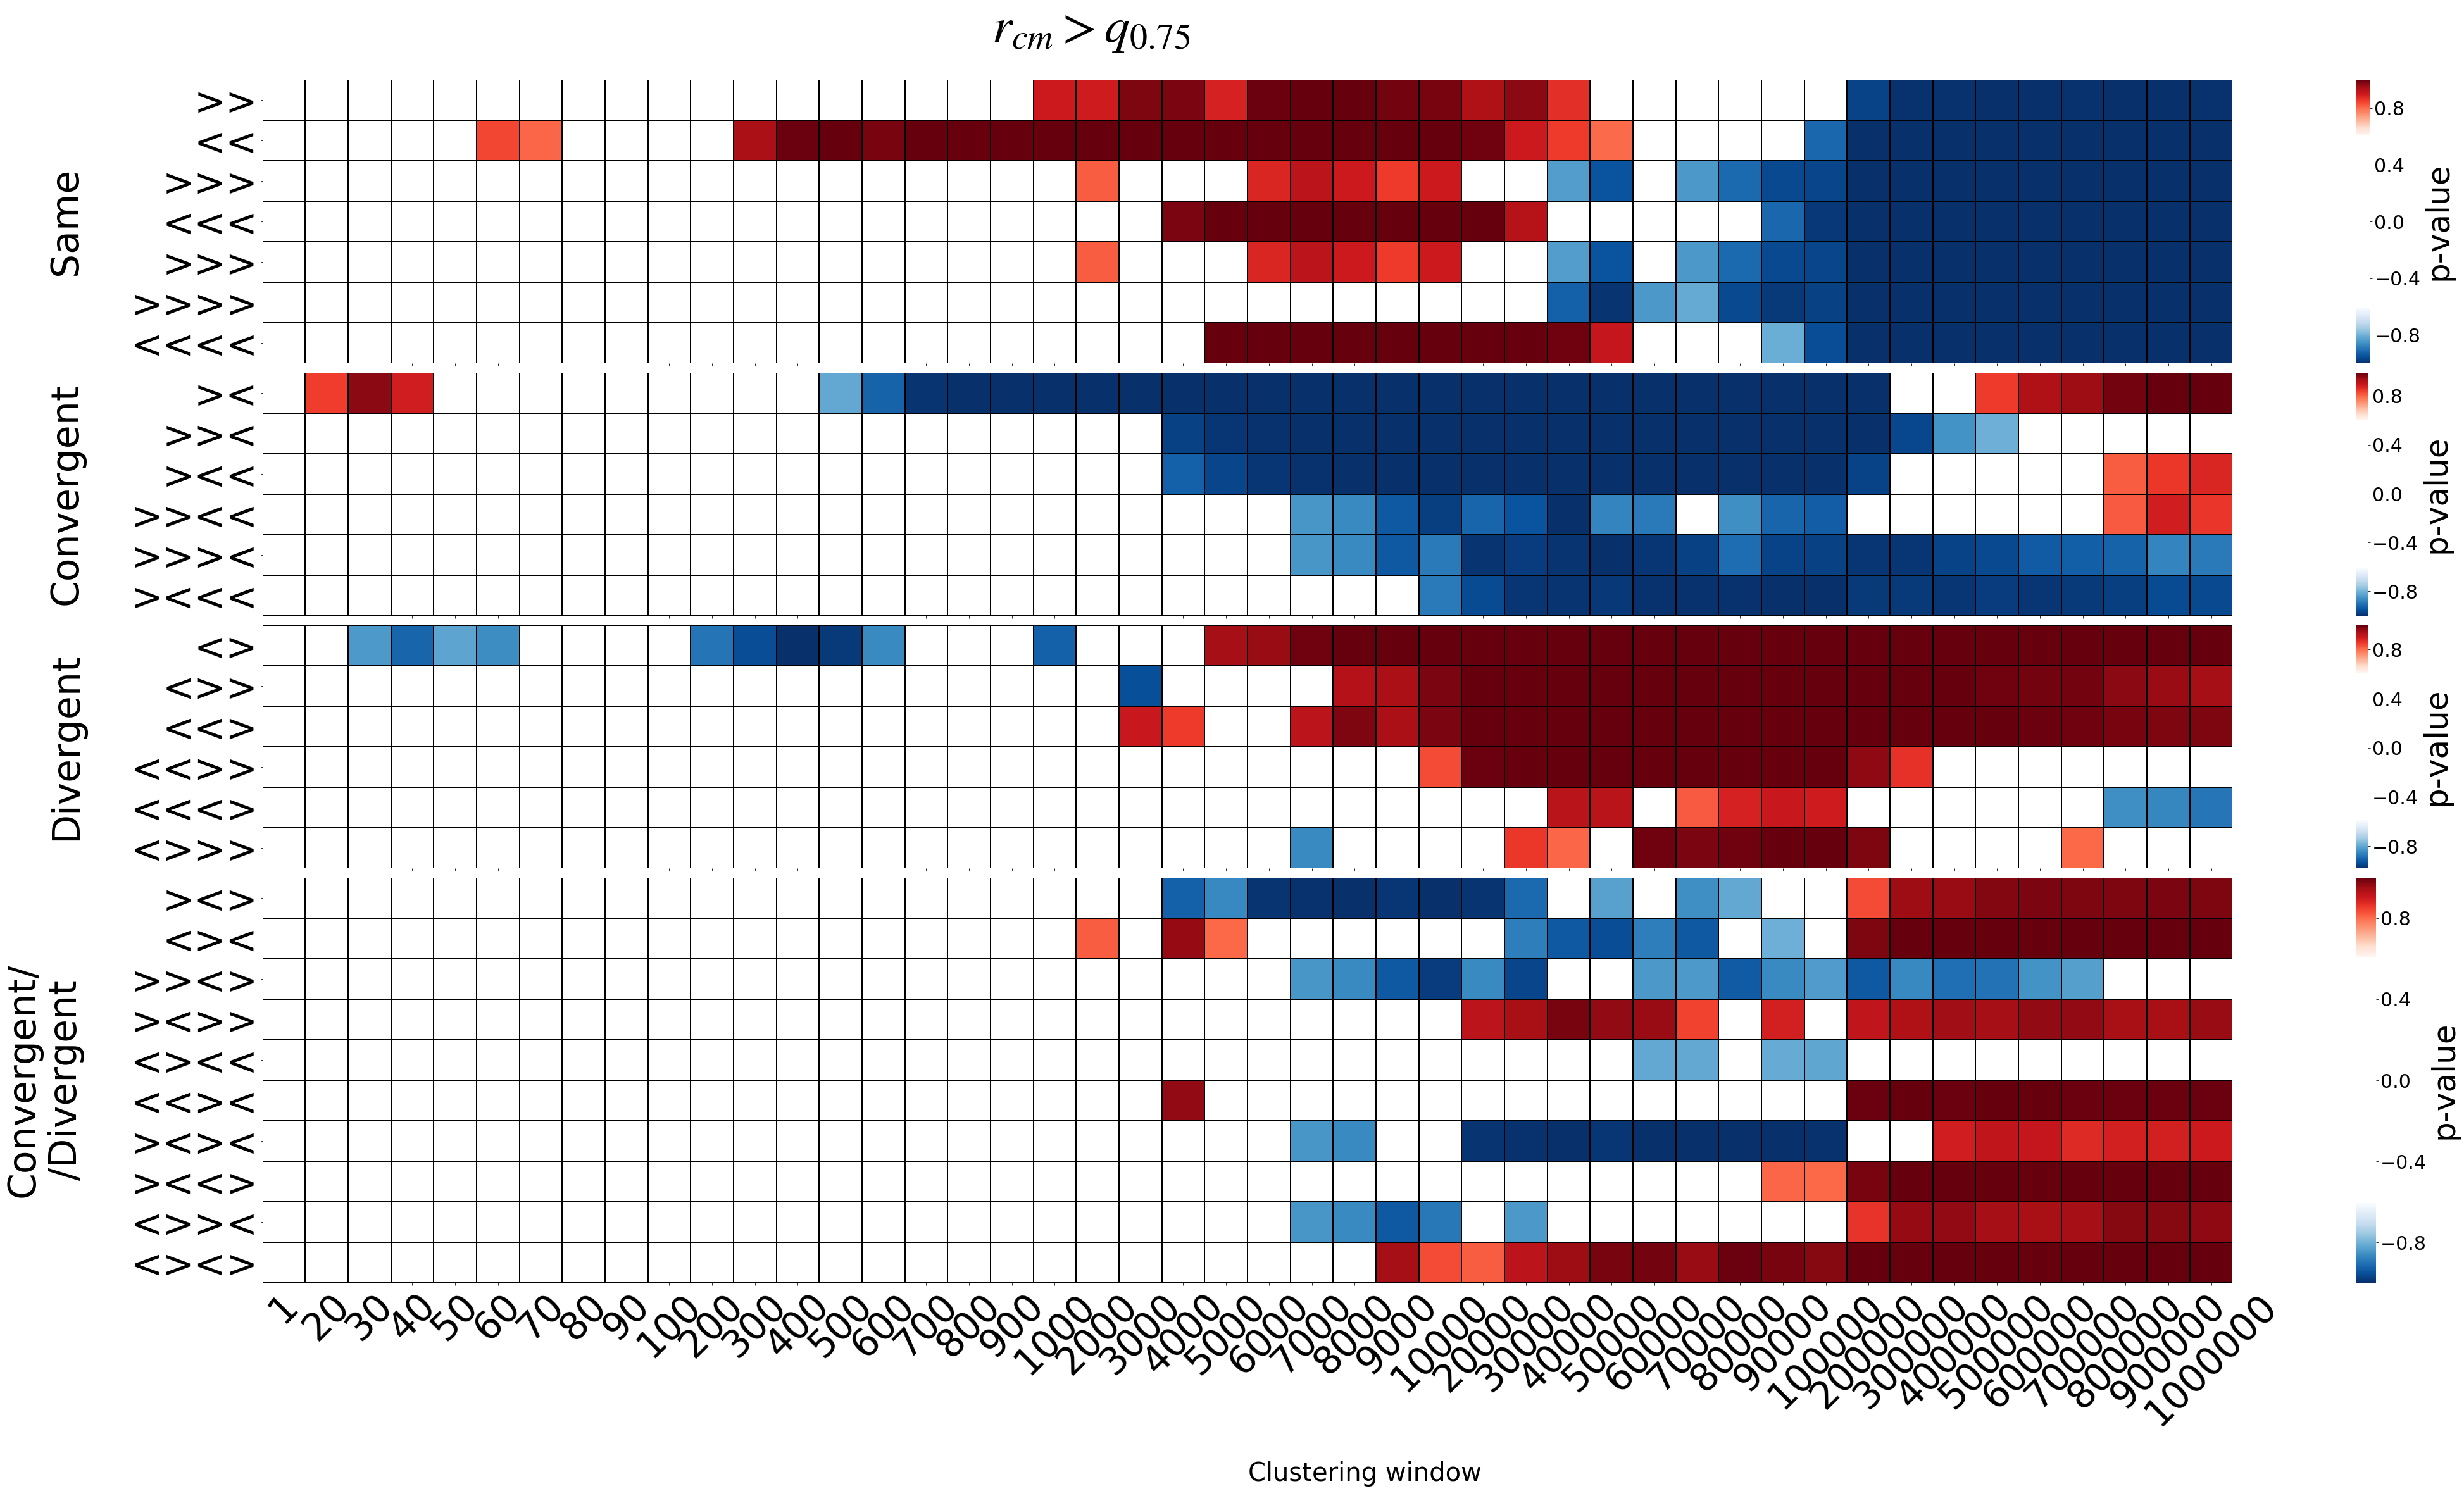

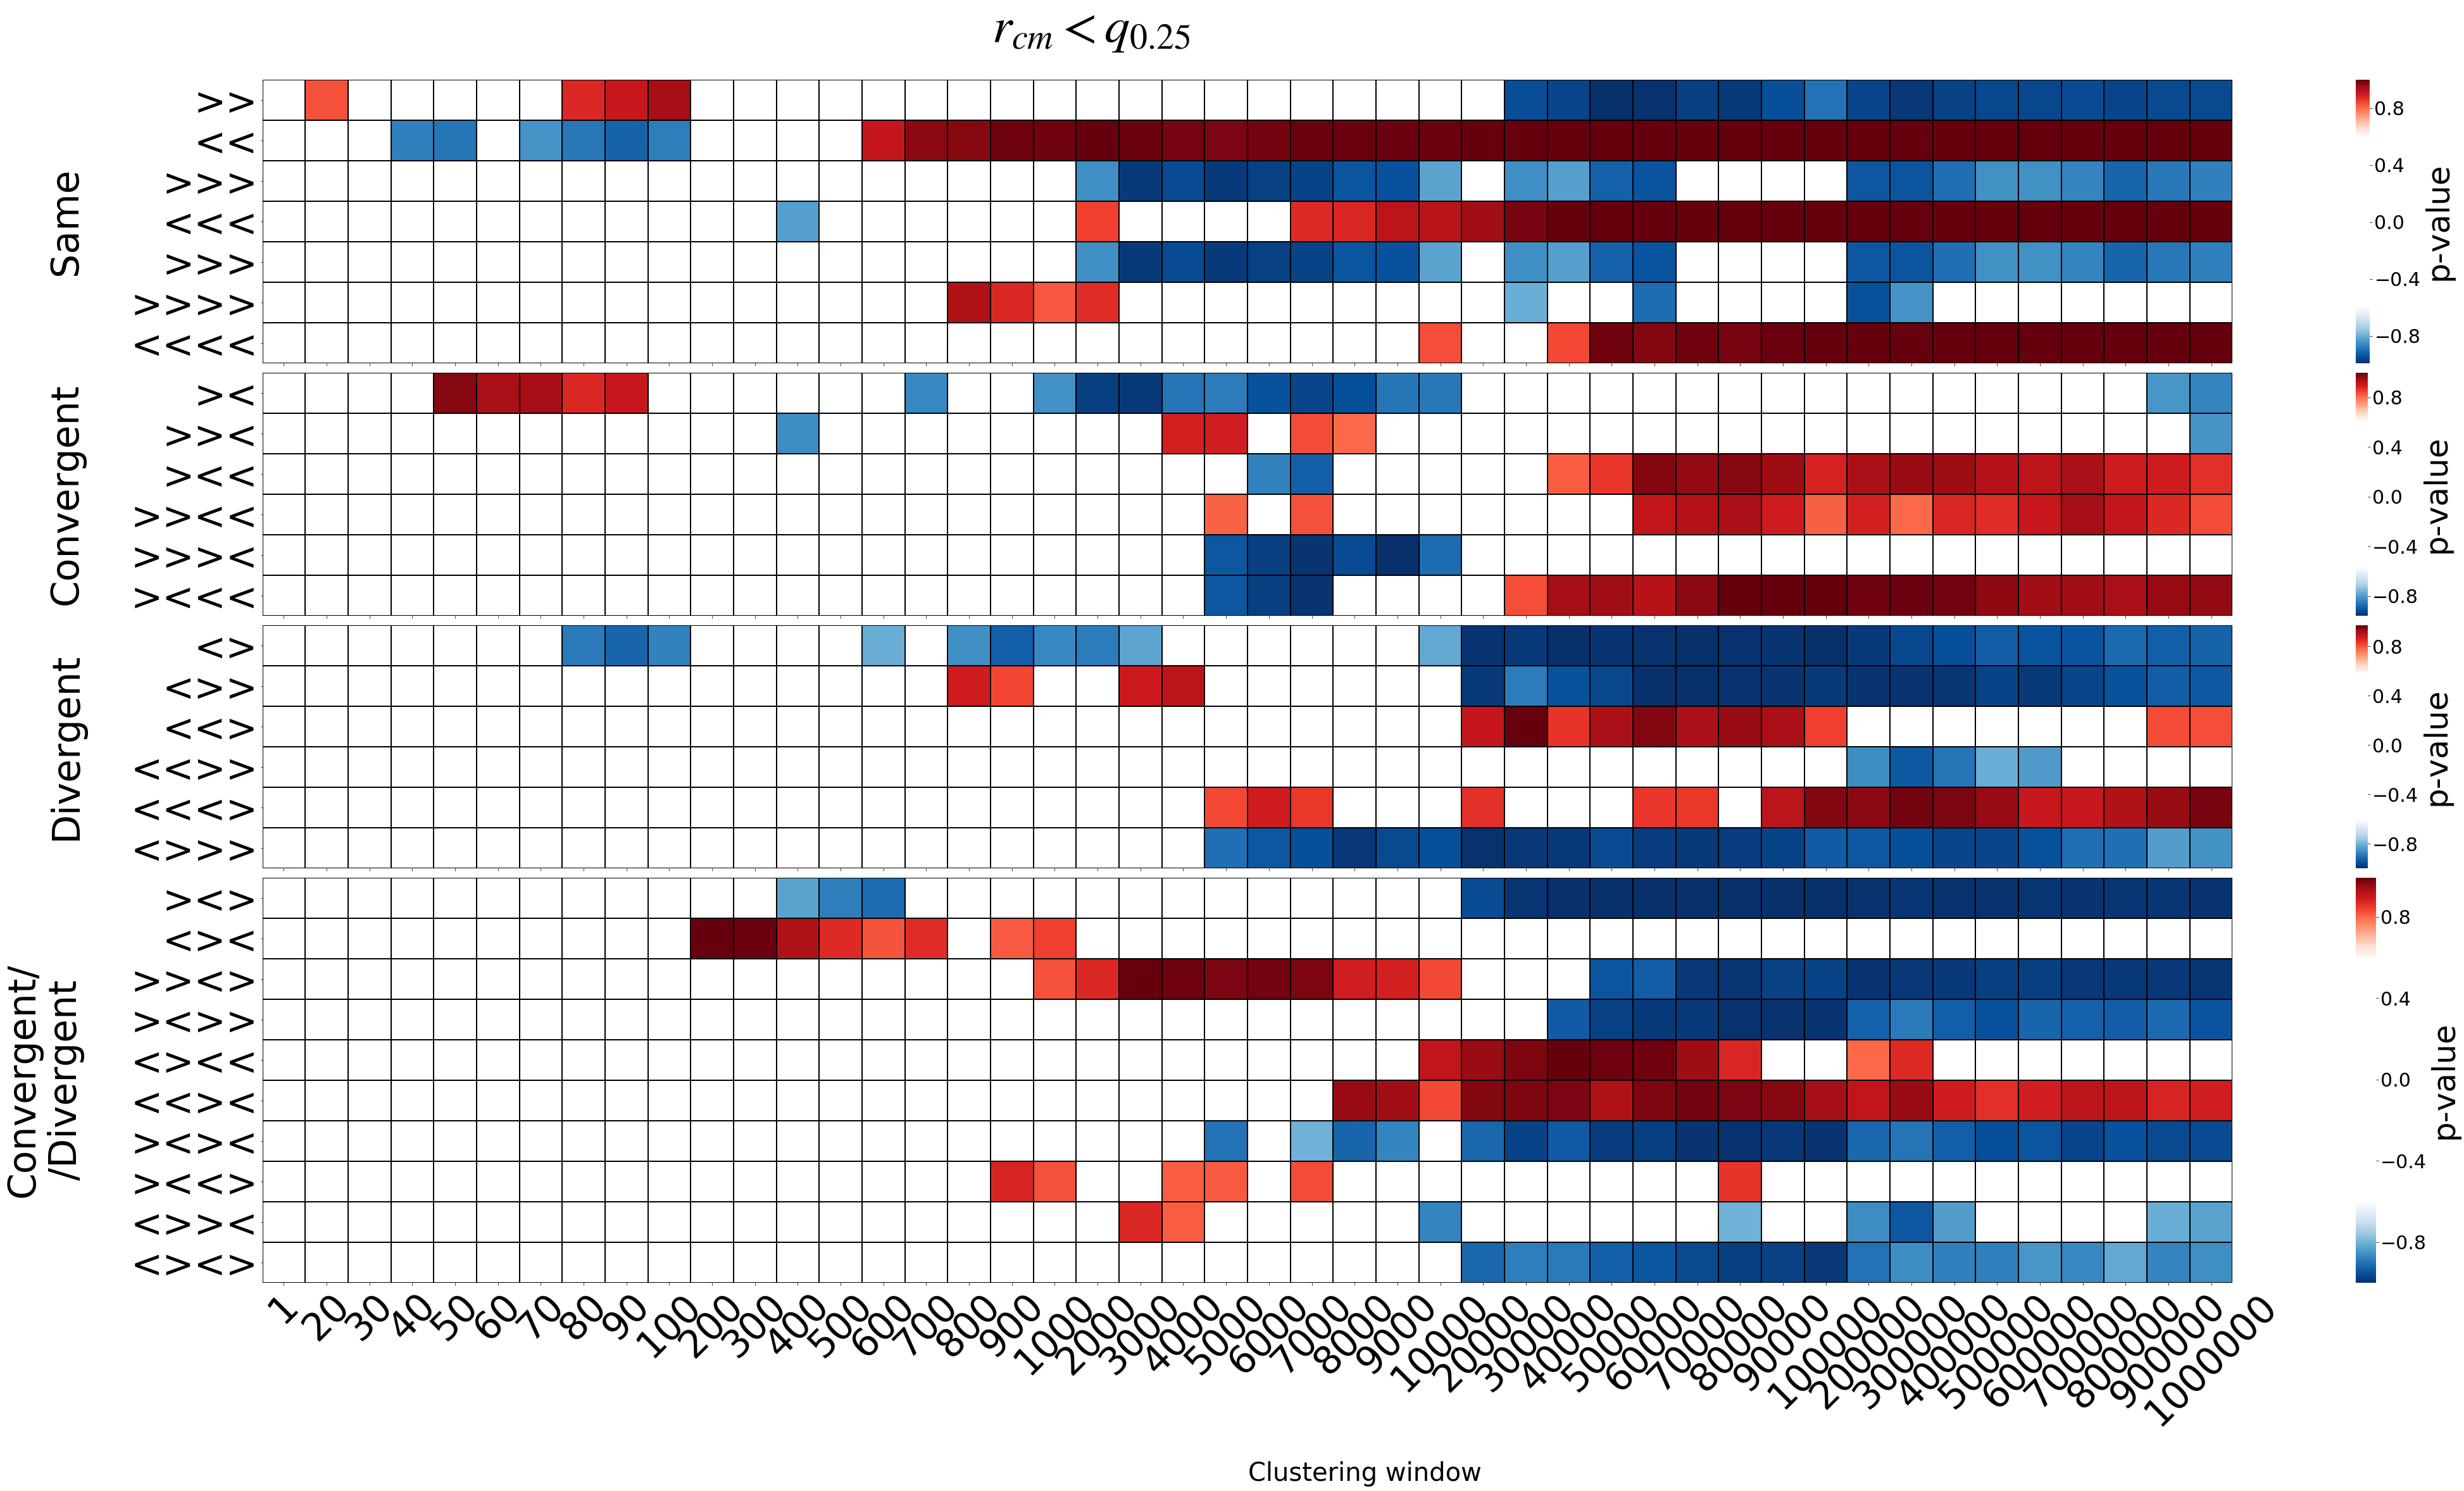

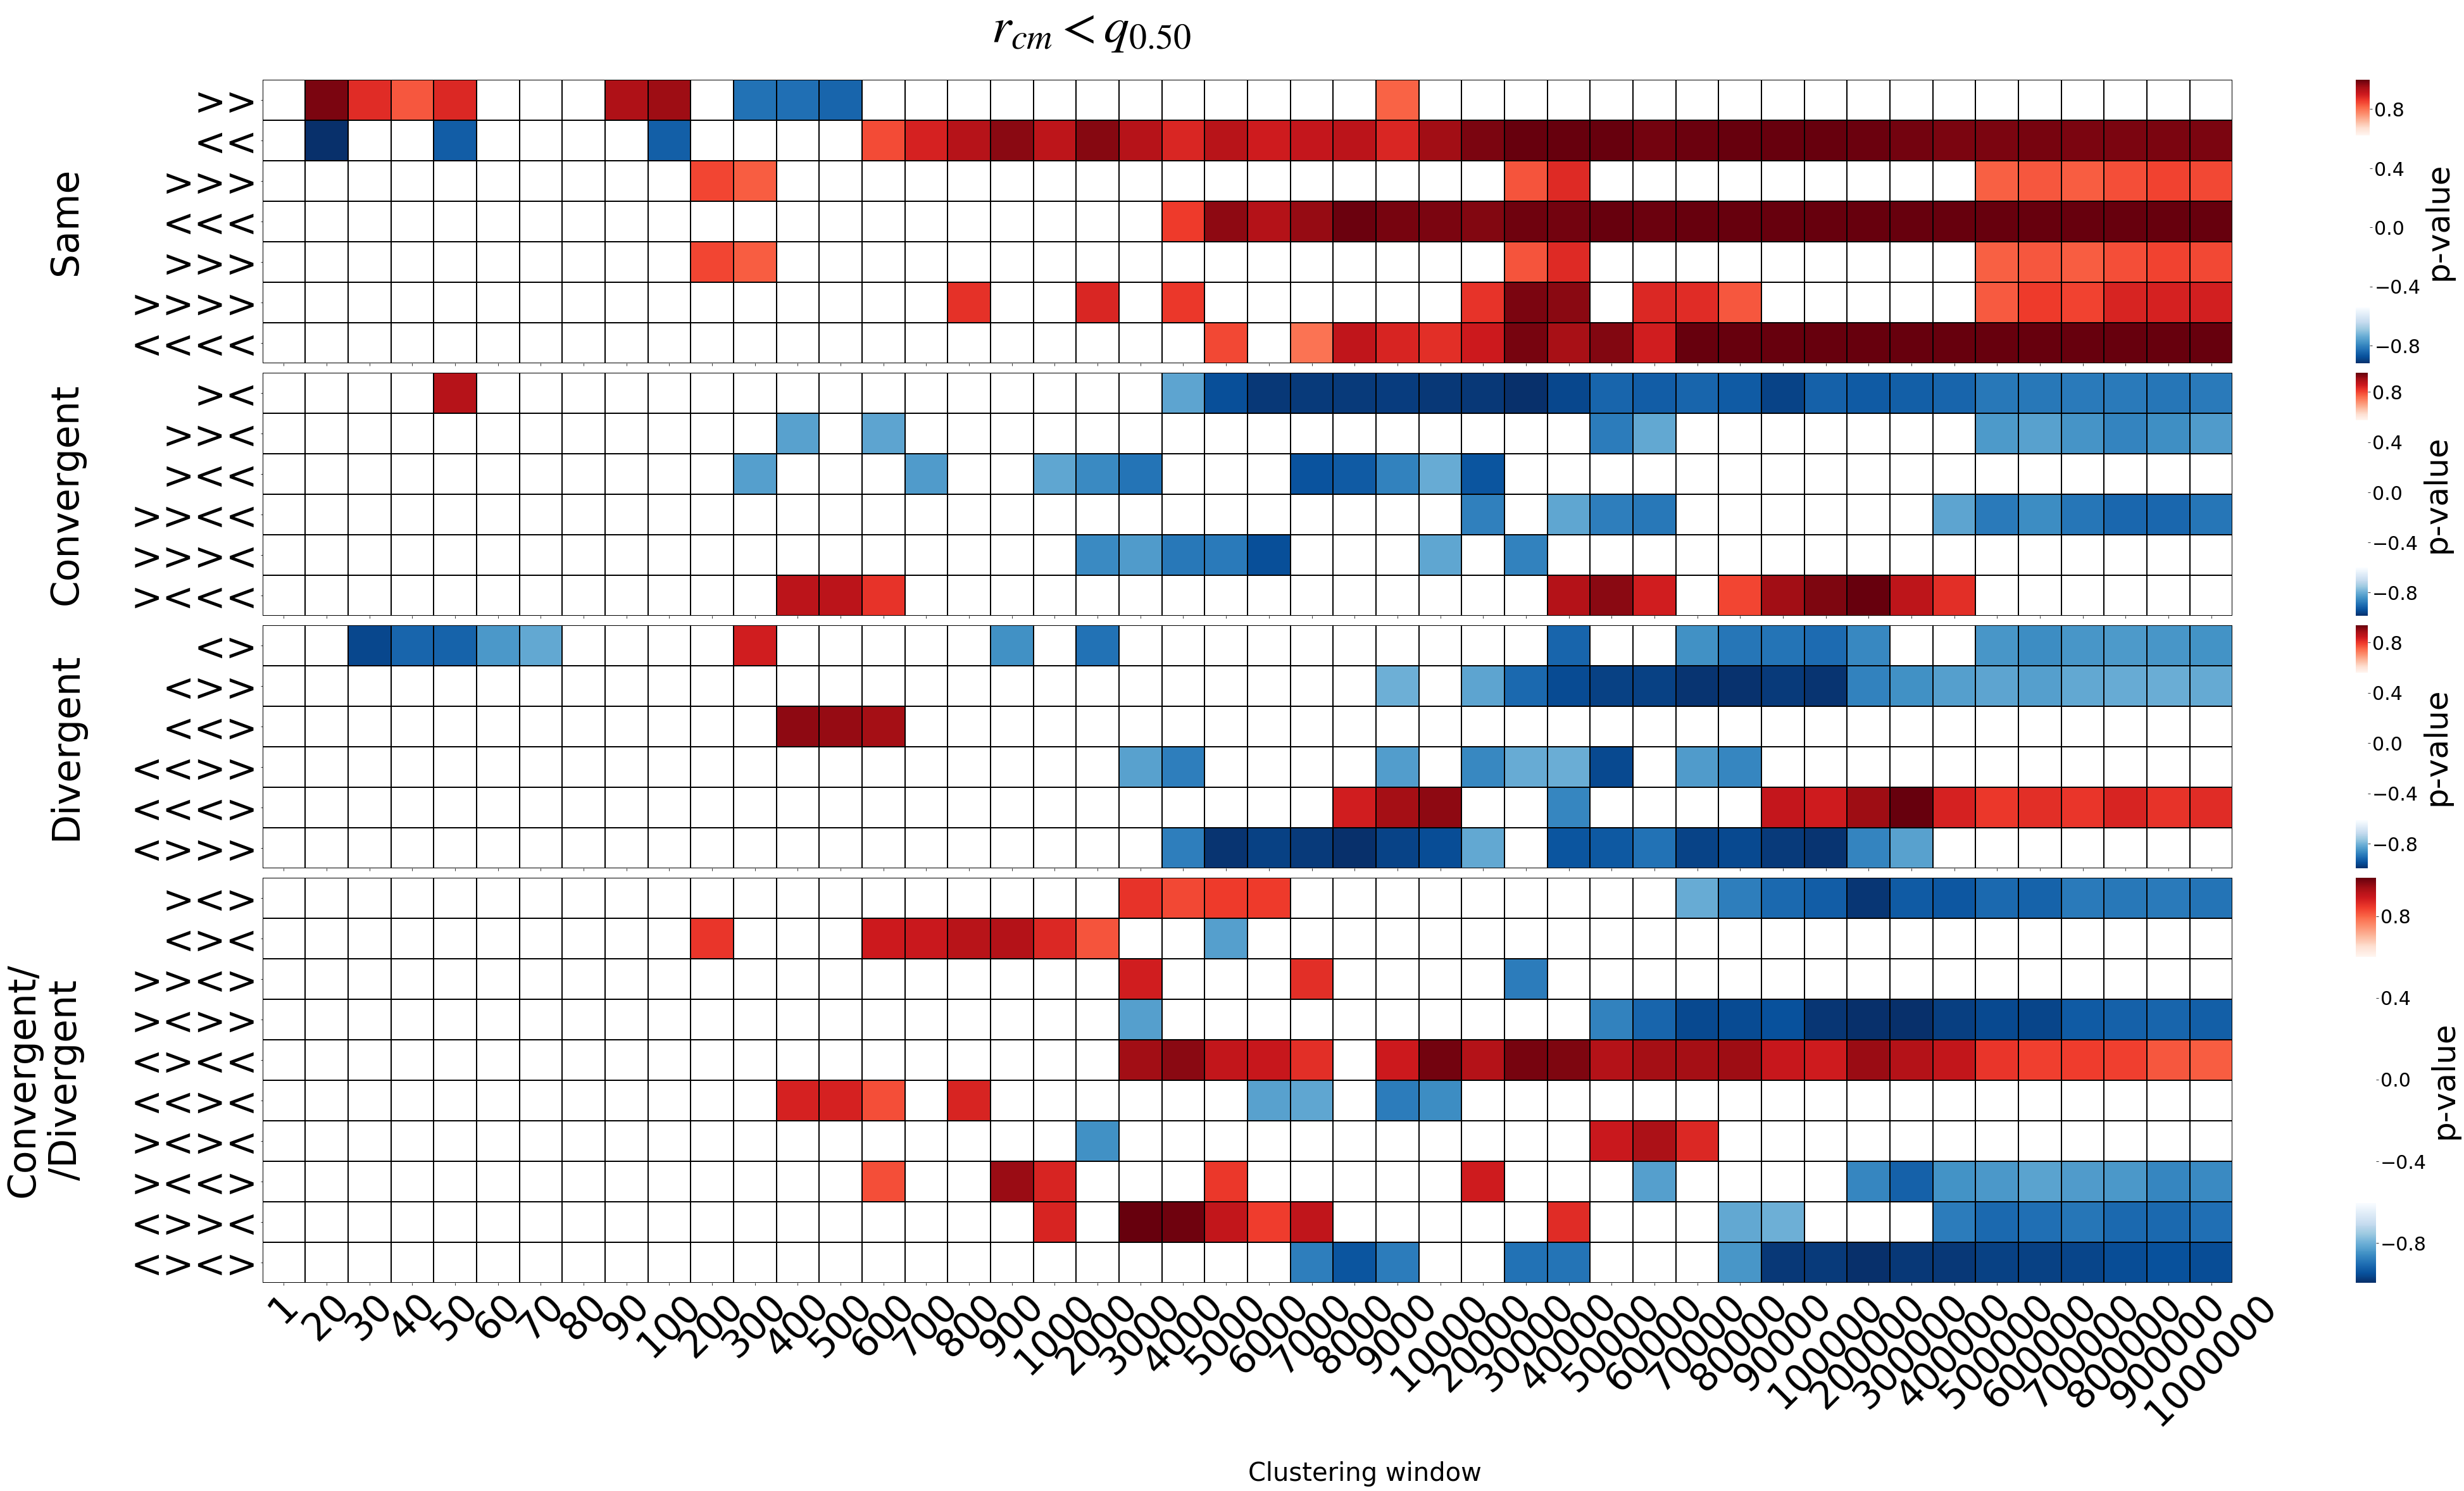

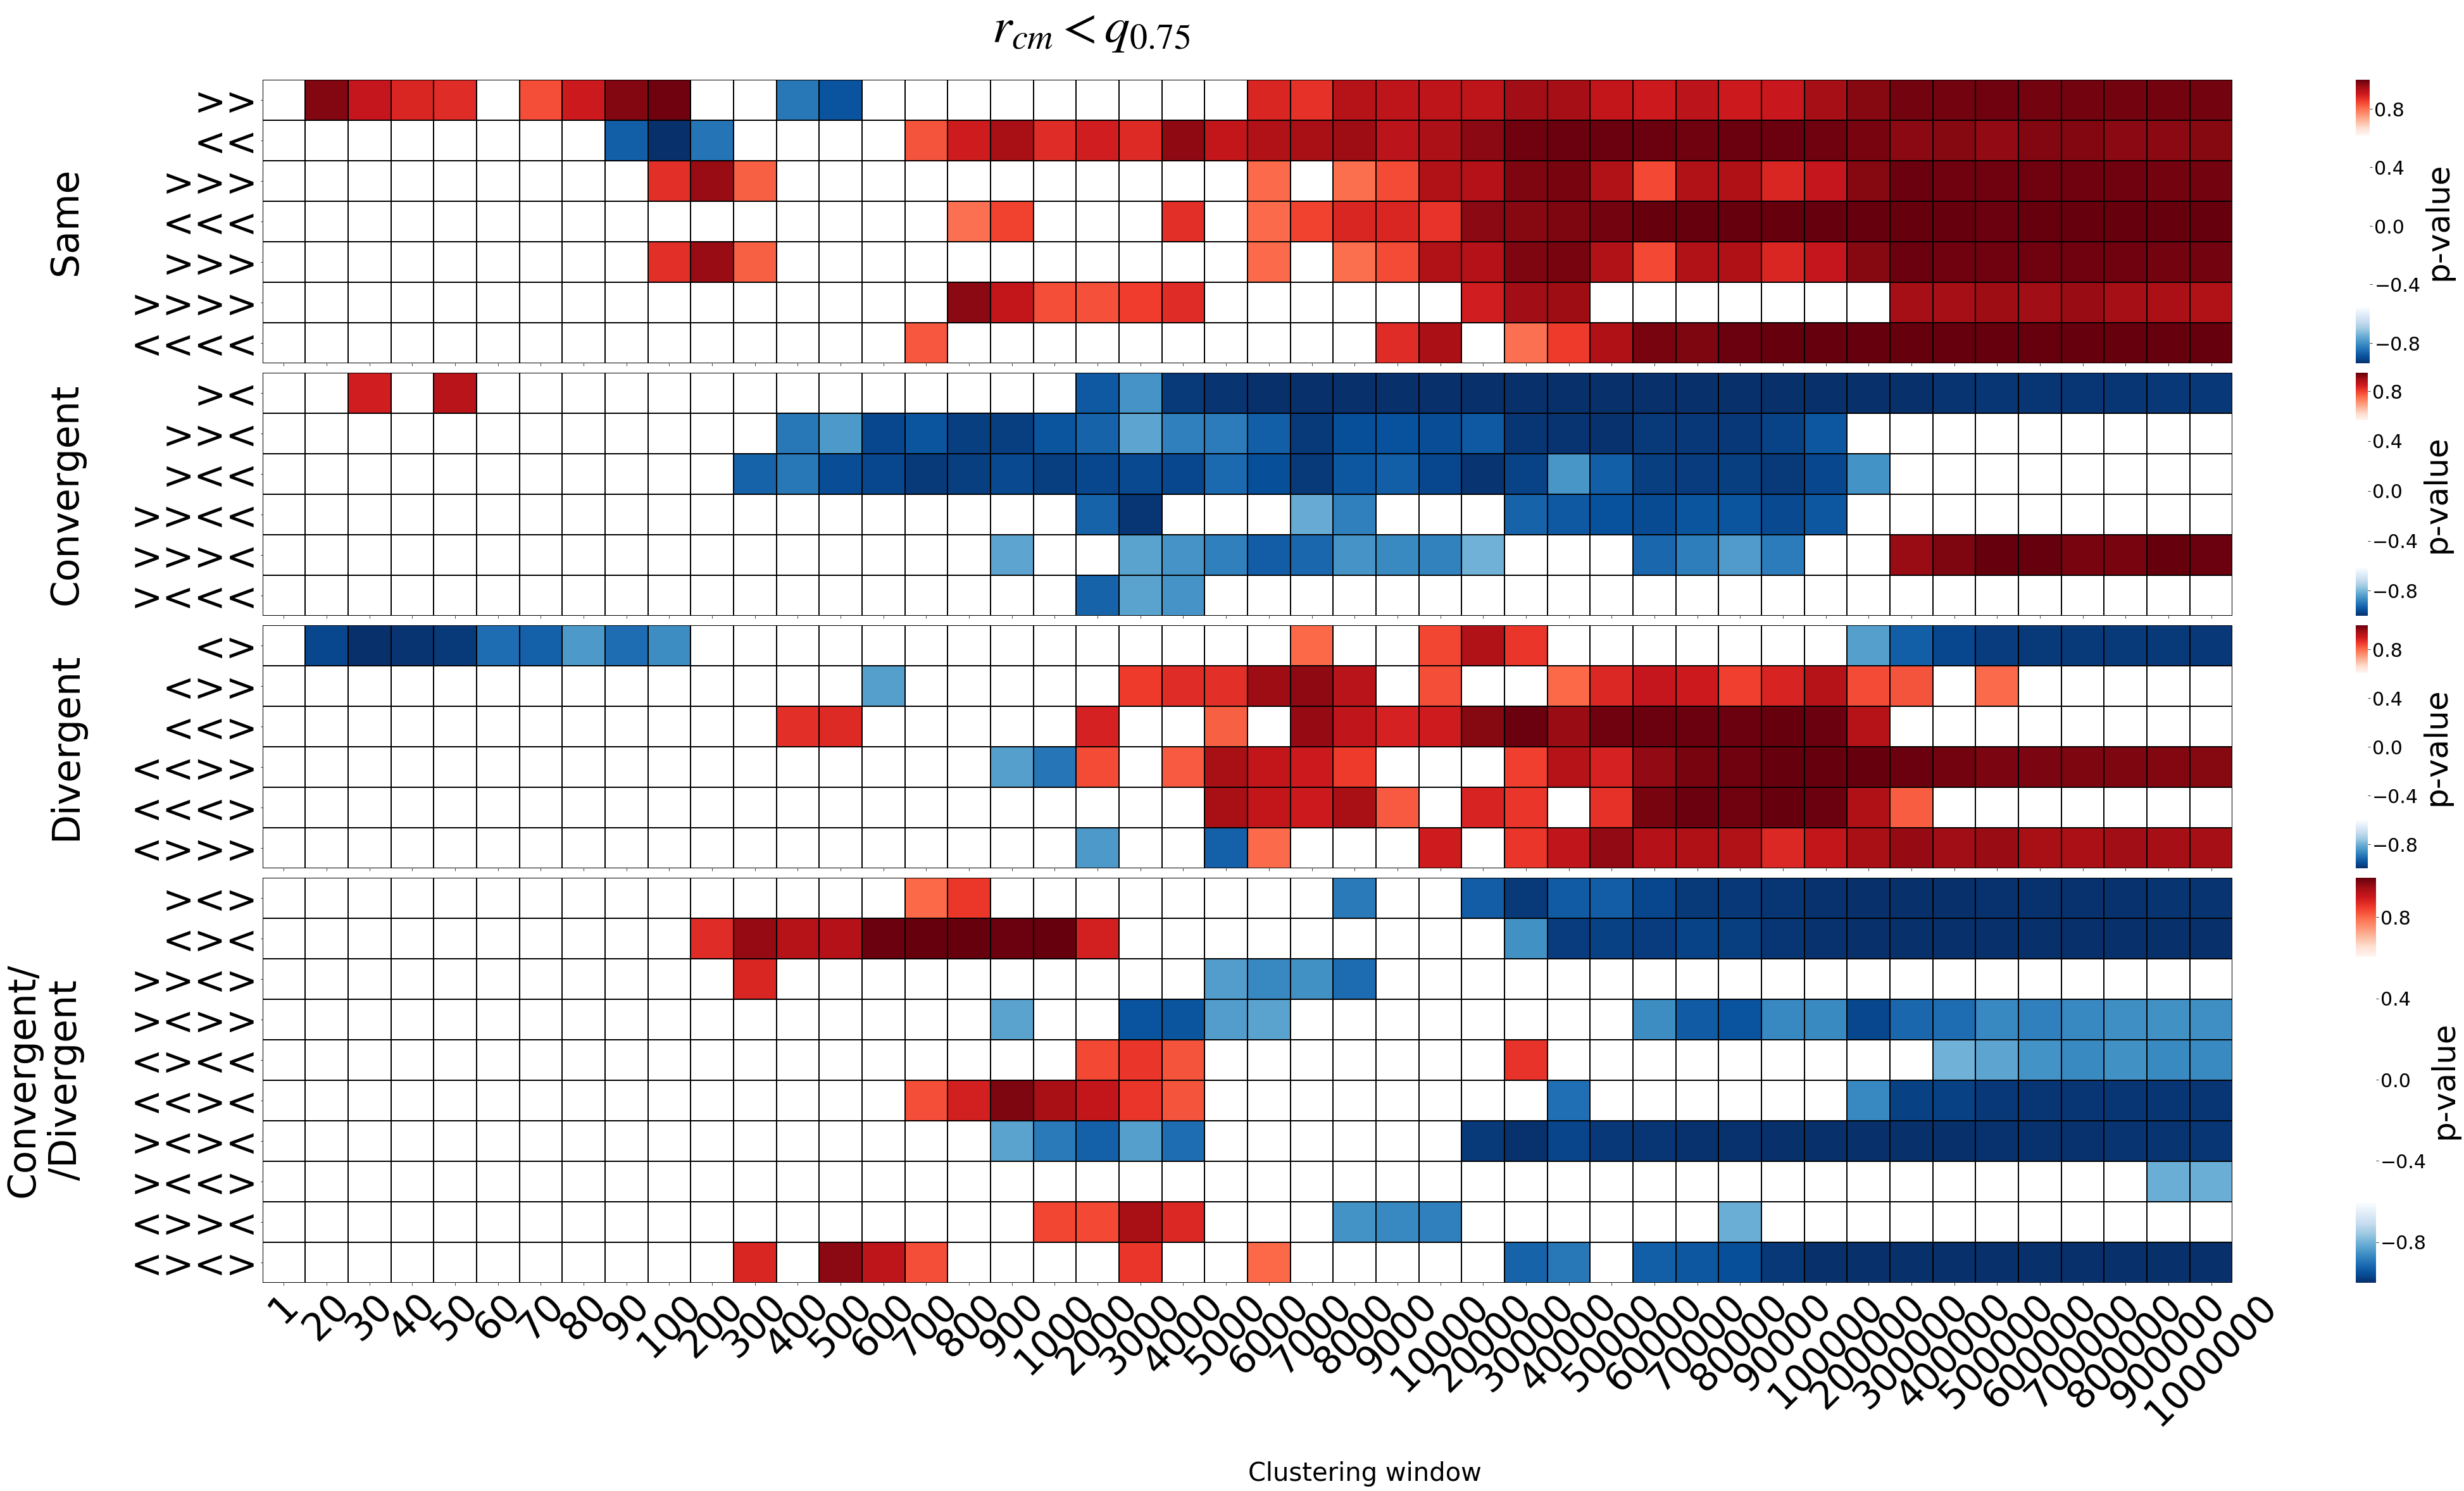

In [291]:
fig = plot_patterns_by_window_and_class_h(ctcfs_greater_25q_pvalues, 
                                 cmap=newcmp, 
                                 mask=None,#pattern_pvalue_by_distance >= significance_level, 
                                 linecolor='black', 
                                 cbar=True, cbar_label="p-value")
fig.suptitle("$r_{cm} > q_{0.25}$", fontsize=80, y=1.05, x=0.4)
fig.savefig(figure_path / "ctcfs_greater_25q_pvalues_by_distance.pdf", bbox_inches='tight', transparent=True)
fig.show()

fig = plot_patterns_by_window_and_class_h(ctcfs_greater_50q_pvalues, 
                                 cmap=newcmp, 
                                 mask=None,#pattern_pvalue_by_distance >= significance_level, 
                                 linecolor='black', 
                                 cbar=True, cbar_label="p-value")
fig.suptitle("$r_{cm} > q_{0.50}$", fontsize=80, y=1.05, x=0.4)
fig.savefig(figure_path / "ctcfs_greater_50q_pvalues_by_distance.pdf", bbox_inches='tight', transparent=True)
fig.show()

fig = plot_patterns_by_window_and_class_h(ctcfs_greater_75q_pvalues, 
                                 cmap=newcmp, 
                                 mask=None,#pattern_pvalue_by_distance >= significance_level, 
                                 linecolor='black', 
                                 cbar=True, cbar_label="p-value")
fig.suptitle("$r_{cm} > q_{0.75}$", fontsize=80, y=1.05, x=0.4)
fig.savefig(figure_path / "ctcfs_greater_75q_pvalues_by_distance.pdf", bbox_inches='tight', transparent=True)
fig.show()

fig = plot_patterns_by_window_and_class_h(ctcfs_lower_25q_pvalues, 
                                 cmap=newcmp, 
                                 mask=None,#pattern_pvalue_by_distance >= significance_level, 
                                 linecolor='black', 
                                 cbar=True, cbar_label="p-value")
fig.suptitle("$r_{cm} < q_{0.25}$", fontsize=80, y=1.05, x=0.4)
fig.savefig(figure_path / "ctcfs_lower_25q_pvalues_by_distance.pdf", bbox_inches='tight', transparent=True)
fig.show()

fig = plot_patterns_by_window_and_class_h(ctcfs_lower_50q_pvalues, 
                                 cmap=newcmp, 
                                 mask=None,#pattern_pvalue_by_distance >= significance_level, 
                                 linecolor='black', 
                                 cbar=True, cbar_label="p-value")
fig.suptitle("$r_{cm} < q_{0.50}$", fontsize=80, y=1.05, x=0.4)
fig.savefig(figure_path / "ctcfs_lower_50q_pvalues_by_distance.pdf", bbox_inches='tight', transparent=True)
fig.show()

fig = plot_patterns_by_window_and_class_h(ctcfs_lower_75q_pvalues, 
                                 cmap=newcmp, 
                                 mask=None,#pattern_pvalue_by_distance >= significance_level, 
                                 linecolor='black', 
                                 cbar=True, cbar_label="p-value")
fig.suptitle("$r_{cm} < q_{0.75}$", fontsize=80, y=1.05, x=0.4)
fig.savefig(figure_path / "ctcfs_lower_75q_pvalues_by_distance.pdf", bbox_inches='tight', transparent=True)
fig.show()

In [ ]:
# all_patterns = []

# for cn, cluster in src.progress(ctcf_clusters.groupby("cluster")):
#     for psize in [1,2,3,4]:
#         idxs = strideby(np.arange(cluster.shape[0], dtype=int), psize)
#         patterns = cluster.orientation.values[idxs].sum(1)
#         starts = cluster.start.values[idxs].min(1)
#         ends = cluster.end.values[idxs].max(1)
        
#         start_ctcf_id = cluster.ctcf_id.values[idxs].min(1)
#         end_ctcf_id = cluster.ctcf_id.values[idxs].max(1)
        
#         df = pd.DataFrame({
#             'chr': cluster.chr.iloc[0],
#             'start': starts,
#             'end': ends,
#             'pattern': patterns,
#             'n_ctcf_sites': psize,
#             'start_ctcf_id': start_ctcf_id,
#             'end_ctcf_id': end_ctcf_id,
#             'size': ends - starts
#         })
#         all_patterns.append(df)
# all_patterns = pd.concat(all_patterns, axis=0)
# all_patterns = all_patterns.sort_values(src.coords).reset_index(drop=True)
# all_patterns.head(10)